<img src="https://www.tu-darmstadt.de/media/resources/images_1/tu_logo_web.svg" width="200">

_________

# 1.2- Geology Classification

* **Date :** 04 February 2023
* **Author :** Augustine M Gbondo ==> Hydrogeologist, Environmental Engineer.
* **Aim :** This notebook aims at analysing Rn-222 data from Hessen District. `pandas` `numpy`, `geopandas`,`shapely`, `seaborn`,`matplotlib` were all utilised to achieve this objective

**Aim**
This notebook aims at classifying the Geology data to use as a feature in the ML algorithms. Two different shapefiles were provided and the most suitable will be used after analysis. `pandas` `numpy`, `geopandas`,`shapely`, `seaborn`,`matplotlib` were all MODULES utilised

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
%matplotlib inline
import warnings

# Auto reloads notebook when changes are made
%reload_ext autoreload
%autoreload 2
warnings.filterwarnings("ignore")

C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
Geology = gpd.read_file("Geology_Hessen/geol_map_UTM32N.shp")
G300k = gpd.read_file("Geology_Hessen/GUEK300_Geol_Hessen.shp")
Radon_merged = gpd.read_file("Radon Hessen/Radon_Hessen.shp")
Final_Radon_data = gpd.read_file("Radon Hessen/Final Rn data.shp")
#checking the crs of the three shapefiles
Geology.crs == G300k.crs == Final_Radon_data.crs

True

In [3]:
Final_Radon_data.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug', 'geometry'],
      dtype='object')

### Analysing G300k shapefile

In [4]:
G300k.head(2)
G300k.columns
G300k.isnull().sum()
print('The columns with at least one null value are : ',
      G300k.isna().any()[lambda x: x])
null_counts = G300k.isnull().sum().sum()

The columns with at least one null value are :  SUBGRUPPE    True
GRUPPE       True
SUBSERIE     True
SERIE        True
SUBSYSTEM    True
dtype: bool


In [5]:
def missing_values_table(G300k):
    mis_val = G300k.isnull().sum()
    mis_val_percent = 100 * G300k.isnull().sum() / len(G300k)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("The G300K dataframe has " + str(G300k.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values = missing_values_table(G300k)
missing_values.head()

The G300K dataframe has 15 columns.
There are 5 columns that have missing values.


Missing Values  % of Total Values
SUBSERIE              119               91.5
SUBSYSTEM             114               87.7
SUBGRUPPE              94               72.3
GRUPPE                 68               52.3
SERIE                  27               20.8

In [6]:
## select columns with geology fetaures
df_G300k = G300k[['FORMATION','PETROGRAPH', 'SUBGRUPPE', 'GRUPPE',
                               'SUBSERIE', 'SERIE', 'SUBSYSTEM','SYSTEM']]
## Geo unique values and their missing value counts
def G300K_data():
    unique_values = pd.DataFrame(df_G300k.nunique())
    null_values = pd.DataFrame(df_G300k.isnull().sum())
    unique_vals_with_null = pd.merge(unique_values, null_values,
                                  left_index=True, right_index=True)
    unique_vals_with_null.columns = ['unique values','null count']
    return unique_vals_with_null

df300k = pd.DataFrame(G300K_data())
df300k

unique values  null count
FORMATION              65           0
PETROGRAPH             76           0
SUBGRUPPE               9          94
GRUPPE                 12          68
SUBSERIE                2         119
SERIE                  17          27
SUBSYSTEM               2         114
SYSTEM                 14           0

**Comments from analysis**
* From the analysis, `FORMATION`, `PETROGRAPH` and `SYSTEM` have complete data
* The former two are with large categories, hence `SYSTEM` was analysed

<AxesSubplot:>

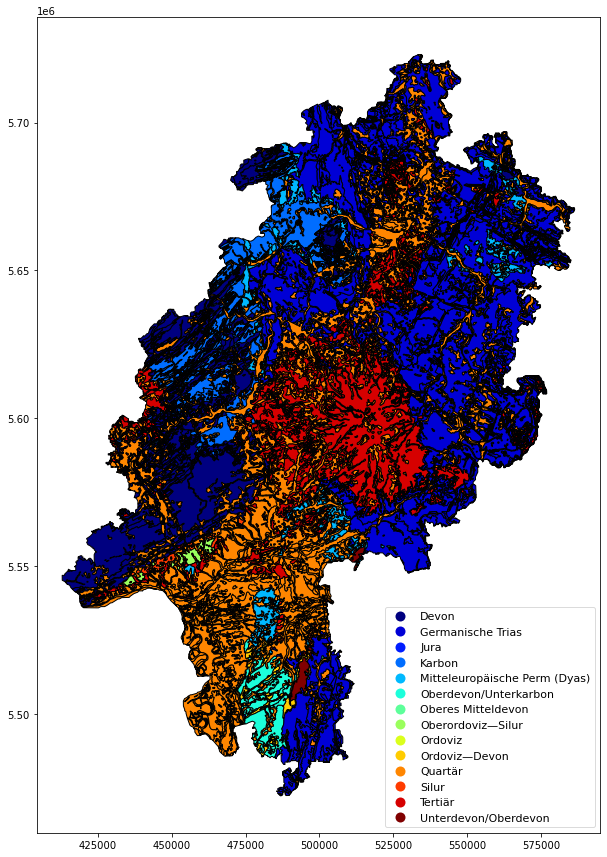

In [7]:
# plotting SYSTEM Geo_class
G300k.plot(column = 'SYSTEM', cmap = 'jet' ,
             figsize = (15,15),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':11,
                         'title_fontsize':13 })
# plt.savefig('SYSTEM_Geo300k.png', dpi='figure')

## **Analysing the Geology shapefile**

In [8]:
print(G300k.columns)
Geology.head(2)

Index(['LAND_ID', 'LAND_TXT', 'GEO_ID', 'GEO_KUERZE', 'FORMATION',
       'PETROGRAPH', 'SUBGRUPPE', 'GRUPPE', 'SUBSERIE', 'SERIE', 'SUBSYSTEM',
       'SYSTEM', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')


FID_1          AREA      PERIMETER  GEO SYMBOL          STRATIGRAP  \
0   8467  6.336117e+08  477448.402231  602      m  Trias, Muschelkalk   
1   8995  2.122375e+08  162134.221355  602      m  Trias, Muschelkalk   

  STRAT_SYM               GENESE GEN_SYM  \
0         m  marine Ablagerungen       m   
1         m  marine Ablagerungen       m   

                                       PETROGRAPH      PET_SYM BEMERKUNGE  \
0  Kalkstein, Mergelstein, Dolomitstein, Tonstein  ^k,^m,^d,^t        NaN   
1  Kalkstein, Mergelstein, Dolomitstein, Tonstein  ^k,^m,^d,^t        NaN   

      SHAPE_Leng                           Strat    Strat2  \
0  770310.108472  Triassic, Middle (Muschelkalk)  Triassic   
1  260817.022729  Triassic, Middle (Muschelkalk)  Triassic   

                            hlnug  Geo_class    Shape_Le_1    Shape_Area  \
0  Triassic, Middle (Muschelkalk)        NaN  75541.621431  9.063963e+07   
1  Triassic, Middle (Muschelkalk)        NaN  36569.019714  1.056687e+07   

                                            geometry  
0  POLYGON ((526957.795 5719576.918, 526874.515 5...  
1  MULTIPOLYGON (((554799.185 5693488.116, 554799...

In [9]:
#renaming strat2 to strat_condense
Geology = Geology.rename(columns = {'Strat2':'strata_condense'})
# select columns with geology fetaures
df_Geo300k = Geology[['STRATIGRAP','Strat', 'strata_condense', 'hlnug',]]

## Geo unique values and their nan value counts
def Geo300K_data():
    unique_value = pd.DataFrame(df_Geo300k.nunique())
    null_value = pd.DataFrame(df_Geo300k.isnull().sum())
    unique_val_with_null = pd.merge(unique_value, null_value,
                                  left_index=True, right_index=True)
    unique_val_with_null.columns = ['unique values','null count']
    return unique_val_with_null

Geo300K_NAN_values = pd.DataFrame(Geo300K_data())
Geo300K_NAN_values

unique values  null count
STRATIGRAP                  65          25
Strat                       26           0
strata_condense             12           0
hlnug                       19           0

**Comments from analysis**
* From the analysis, `Strat`, `strata-condense` and `hlnug` have complete data
* Since our aim is to downsize classification, we choose the `strata_condense` and `hlnug`

**`hlnug`**

<AxesSubplot:>

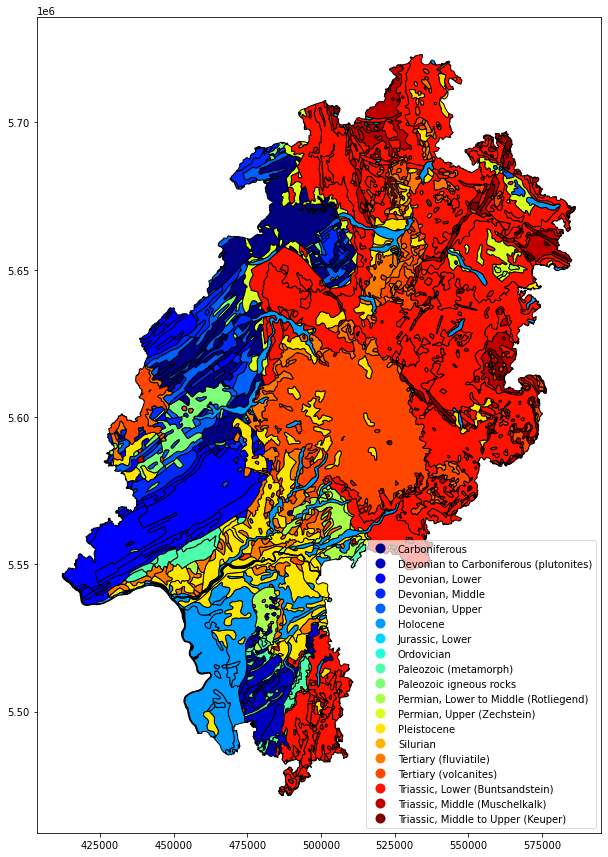

In [10]:
# plotting ''hlnug'
Geology.plot(column = 'hlnug', cmap = 'jet',
             figsize = (15,15),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':10,
                         'title_fontsize':13 })
# plt.savefig('hlnug_Geo300k.png', dpi='figure', )

**`strata_condense`**

<AxesSubplot:>

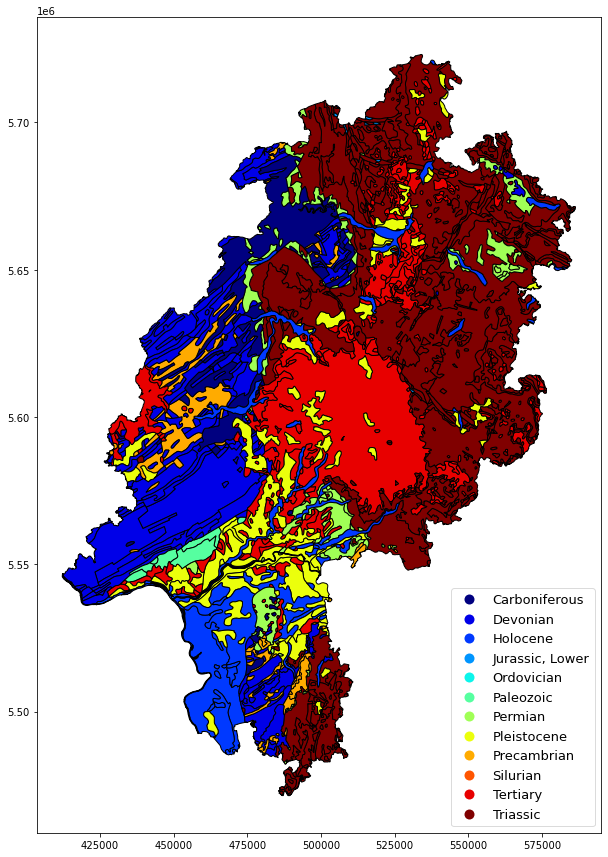

In [11]:
# plotting 'strata_condense'
Geology.plot(column = 'strata_condense', cmap = 'jet',
             figsize = (15,15),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
# plt.savefig('strata_Geo300k.png', dpi='figure', )

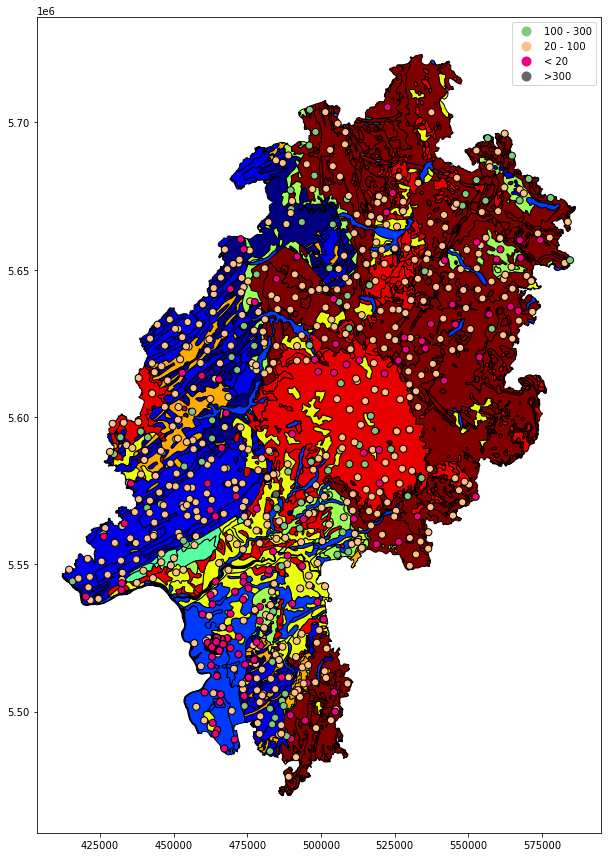

In [12]:
# plotting Radon data and Geology
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Geology.plot(ax = ax, column = 'strata_condense', cmap = 'jet',
             figsize = (18,18),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
ax2 = Final_Radon_data.plot(ax = ax, column = 'RnKONZE',
           cmap = 'Accent', edgecolor='black', markersize = 50, legend = True)

In [13]:
#Joining the Geology and Rn shapefiles 
#checking both crs
print(Final_Radon_data.crs == Geology.crs)
#merging both point and polygon data
Geo_Radon = gpd.sjoin(Final_Radon_data, Geology, how='inner', predicate='within')
Geo_Radon.head(3)
Geo_Radon.columns

True


Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug_left', 'geometry',
       'index_right', 'FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL',
       'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM',
       'BEMERKUNGE', 'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug_right',
       'Geo_class', 'Shape_Le_1', 'Shape_Area'],
      dtype='object')

In [14]:
Geo_Radon['hlnug_right'].unique()

array(['Pleistocene', 'Holocene', 'Triassic, Lower (Buntsandstein)',
       'Devonian to Carboniferous (plutonites)', 'Paleozoic (metamorph)',
       'Carboniferous', 'Permian, Lower to Middle (Rotliegend)',
       'Triassic, Middle to Upper (Keuper)', 'Permian, Upper (Zechstein)',
       'Triassic, Middle (Muschelkalk)', 'Devonian, Upper',
       'Tertiary (volcanites)', 'Tertiary (fluviatile)',
       'Devonian, Lower', 'Devonian, Middle', 'Paleozoic igneous rocks'],
      dtype=object)

### ANOVA TESTS

#### Hypothesis Testing
* Ho --> There is no difference between Geology and Radon
* H1 -->There is a difference between Geology and Rn

##### Geology --> hnlug

Text(0.5, 1.0, 'BOXplot of GRP and hlnug strata')

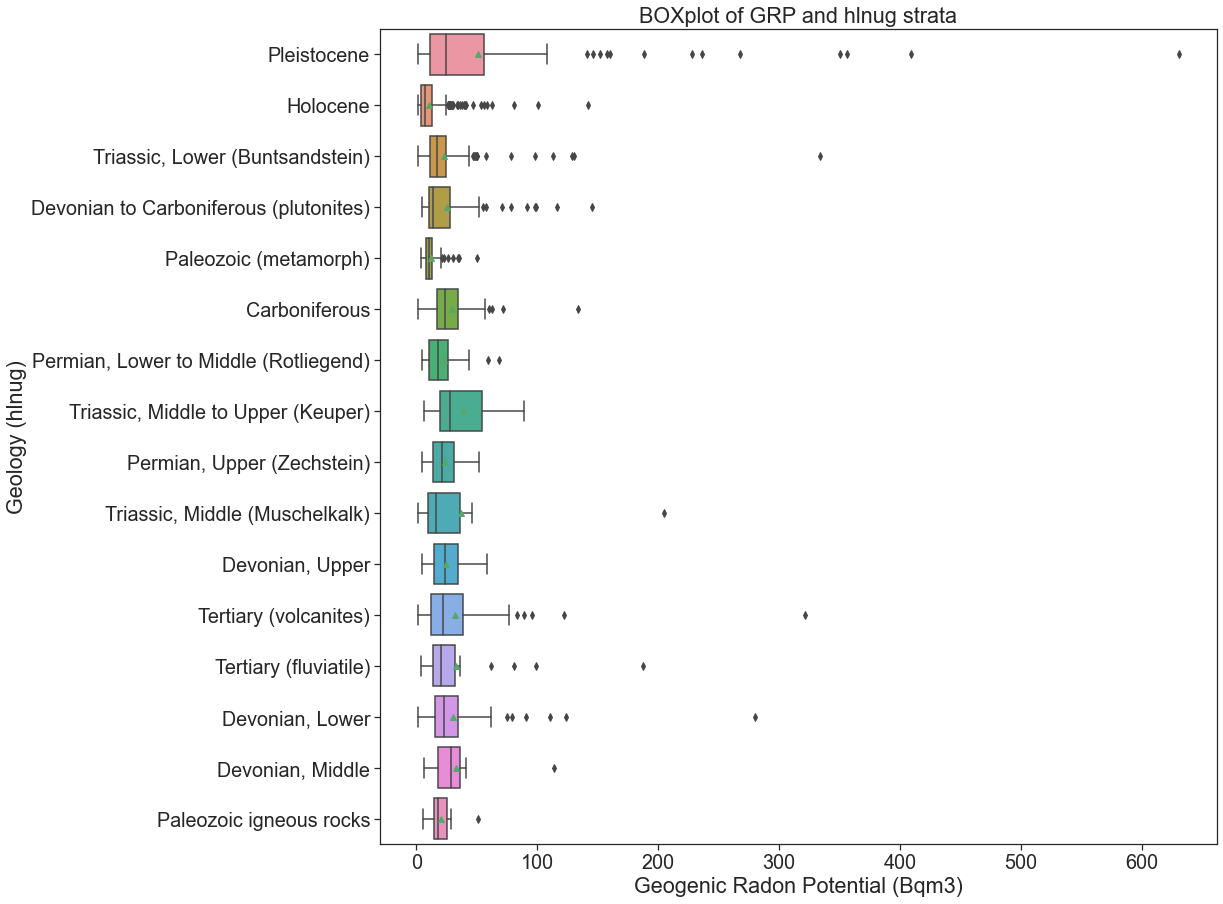

In [15]:
# BOXplot of hlnug strata
## Setting theme for plots
sns.set_theme(style='ticks', font_scale=1.8)
plt.figure(figsize=(15,15))
#Plotting GRP values of geology
sns.boxplot(y='hlnug_right', x='Rn_Poten',
            data= Geo_Radon,showmeans = True,
            dodge=True )
plt.ylabel ('Geology (hlnug)')
plt.xlabel ('Geogenic Radon Potential (Bqm3)')
plt.title('BOXplot of GRP and hlnug strata')
# plt.savefig('BOXplot of GRP and hlnug strata.png', dpi='figure', )

**`Strat2`:**  melted classes

Text(0.5, 1.0, 'BOXplot of GRP and strata_condensed strata')

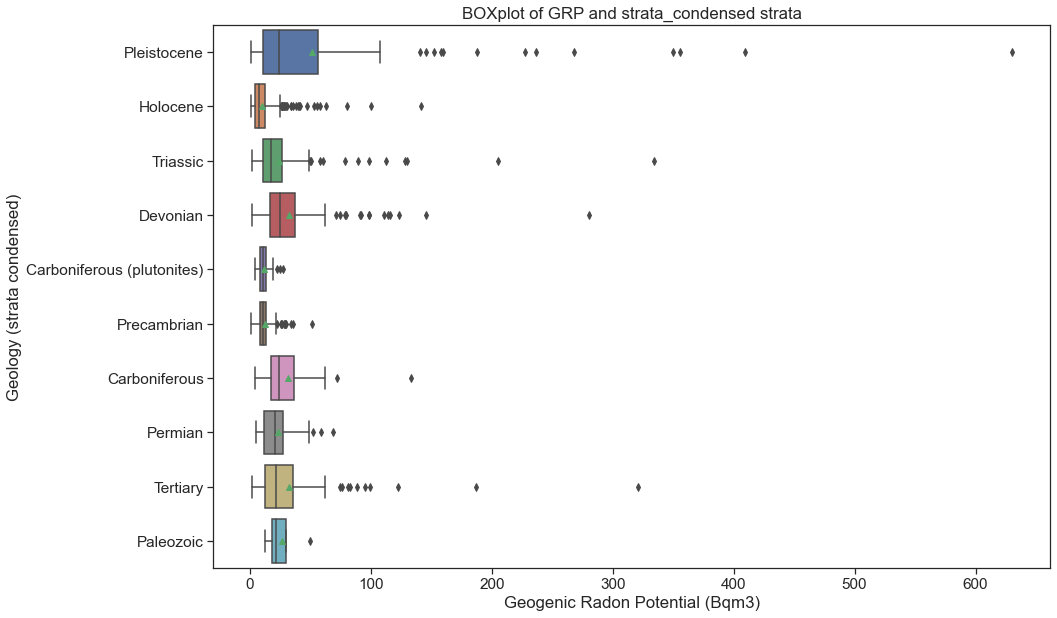

In [16]:
# BOXplot of strata_condense strata
## Setting theme for plots
sns.set_theme(style='ticks', font_scale=1.4)
plt.figure(figsize=(15,10))
#Plotting GRP values of geology
sns.boxplot(y='Strat2', x='Rn_Poten',
            data= Geo_Radon, showmeans = True,
            dodge=True )
plt.ylabel ('Geology (strata condensed)')
plt.xlabel ('Geogenic Radon Potential (Bqm3)')
plt.title('BOXplot of GRP and strata_condensed strata')
# plt.savefig('BOXplot of strata_condense strata.png', dpi='figure', )

In [17]:
# Pivot table by Randon-int and aggregate the ratings with their average
mean_Radon_int = Geo_Radon.pivot_table(index="RnKONZE",
                                  columns="Strat2",
                                  values="Rn_Poten",
                                  aggfunc="count")

# sort by the least occurrence of NAs, 
mean_Radon_int.iloc[mean_Radon_int.isnull()
                    .sum(axis=1).argsort()].fillna("-").head(10)

Strat2    Carboniferous Carboniferous (plutonites) Devonian Holocene  \
RnKONZE                                                                
20 - 100           30.0                        3.0    119.0     48.0   
< 20                5.0                       42.0     16.0    499.0   
100 - 300           6.0                          -     25.0      2.0   
>300                  -                          -        -        -   

Strat2    Paleozoic Permian  Pleistocene Precambrian Tertiary Triassic  
RnKONZE                                                                 
20 - 100        4.0    29.0         52.0        28.0     67.0    145.0  
< 20              -     4.0         45.0       111.0     12.0     36.0  
100 - 300         -     5.0         33.0           -     17.0     23.0  
>300              -       -         18.0           -        -        -

In [18]:
Geo_Radon.describe()

OSTWERT      NORDWERT     Rn_Poten    RADON_RN_2   RADON_RN_3  \
count    1424.000000  1.424000e+03  1424.000000  1.424000e+03  1424.000000   
mean   479896.736962  5.557858e+06    21.655689  2.682075e+04    53.298796   
std     28764.517014  5.169572e+04    36.185972  9.702013e+04    98.171915   
min    414476.771000  5.477873e+06     1.041721  0.000000e+00     1.415790   
25%    463355.000000  5.521652e+06     6.745734  0.000000e+00    19.365443   
50%    468257.677000  5.525000e+06    12.762669  6.586711e+03    34.167070   
75%    487078.529825  5.585673e+06    22.730340  2.832445e+04    60.000588   
max    584540.000000  5.705172e+06   630.270000  1.892352e+06  1892.352000   

       index_right         FID_1          AREA     PERIMETER          GEO  \
count  1424.000000   1424.000000  1.424000e+03  1.424000e+03  1424.000000   
mean   1020.358146  14964.181882  4.182359e+08  2.957365e+05   388.750702   
std     264.378098   3228.131832  6.023696e+08  4.014728e+05   333.644989   
min       0.000000   8467.000000  4.568436e+05  3.008484e+03    24.000000   
25%     940.000000  13427.000000  1.091713e+07  1.884425e+04    24.000000   
50%    1045.000000  13908.000000  2.191741e+08  2.101561e+05   519.000000   
75%    1198.250000  14907.750000  5.787977e+08  4.482985e+05   692.000000   
max    1406.000000  22653.000000  2.841656e+09  2.149762e+06   839.000000   

         SHAPE_Leng  Geo_class    Shape_Le_1    Shape_Area  
count  1.424000e+03        0.0  1.424000e+03  1.424000e+03  
mean   4.621799e+05        NaN  2.402614e+05  3.402846e+08  
std    6.310918e+05        NaN  2.973297e+05  4.841265e+08  
min    4.677551e+03        NaN  3.009346e+03  4.572413e+05  
25%    2.943739e+04        NaN  1.844411e+04  1.003629e+07  
50%    3.357531e+05        NaN  1.864537e+05  2.193354e+08  
75%    6.939851e+05        NaN  3.602108e+05  4.669677e+08  
max    3.384736e+06        NaN  1.521409e+06  1.978637e+09

Text(0.5, 1.0, 'mean values of GRP by geology based on intervals')

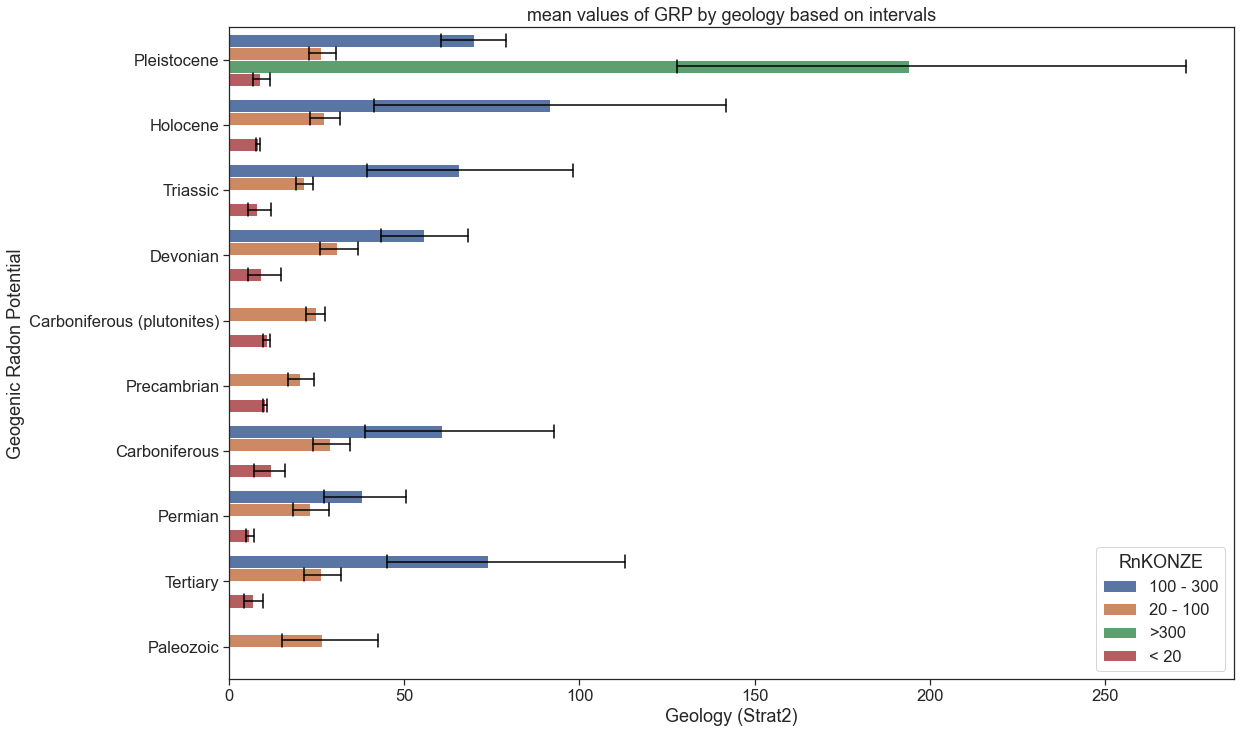

In [19]:
#Plotting mean values GRP by geology based on intervals
sns.set_theme(style='ticks', font_scale=1.5)
plt.figure(figsize=(18,12))
sns.barplot(y='Strat2', x='Rn_Poten',
            data= Geo_Radon, estimator= np.mean, hue='RnKONZE',
            errcolor = 'black', errwidth = 1.5,
            capsize=0.2)
plt.xlabel ('Geology (Strat2)')
plt.ylabel ('Geogenic Radon Potential')
plt.title('mean values of GRP by geology based on intervals')
# plt.savefig('mean values GRP by geology based on intervals.png', dpi='figure', )

Text(0.5, 1.0, 'STRIPplot of Final_Radon_data BY strat_condense ')

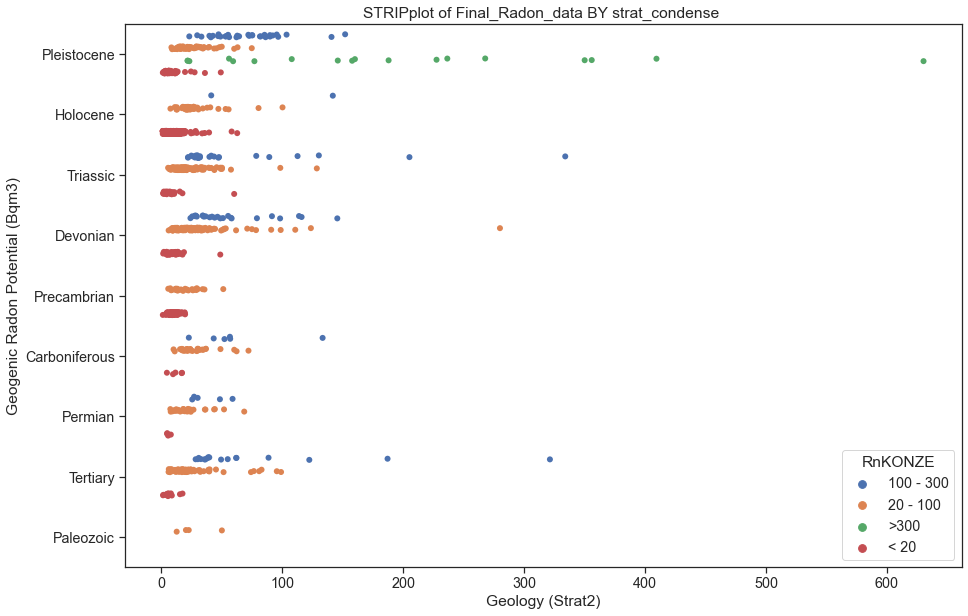

In [20]:
## STRIPplot of Final_Radon_data BY strat_condense 
sns.set_theme(style='ticks', font_scale=1.3)
plt.figure(figsize=(15,10))
sns.stripplot(data=Geo_Radon,
              x='Rn_Poten',y='strata_condense',hue='RnKONZE',
              size=6,edgecolor='black', dodge=True)

plt.xlabel ('Geology (Strat2)')
plt.ylabel ('Geogenic Radon Potential (Bqm3)')
plt.title('STRIPplot of Final_Radon_data BY strat_condense ')
# plt.savefig('STRIPplot of Final_Radon_data BY strat_condense .png',dpi='figure', )

## Statistical Analysis of relationship between Geology and Radon measurements

**1. hlnug**

In [21]:
#mean of different classes 
mean_Radon_int = Geo_Radon.pivot_table(index='RnKONZE', columns="hlnug_right", 
                                         values="Rn_Poten", aggfunc="median")
mean_Radon_int

hlnug_right  Carboniferous  Devonian to Carboniferous (plutonites)  \
RnKONZE                                                              
100 - 300         54.43425                                57.62980   
20 - 100          23.91300                                26.81320   
< 20              10.65146                                10.91796   
>300                   NaN                                     NaN   

hlnug_right  Devonian, Lower  Devonian, Middle  Devonian, Upper   Holocene  \
RnKONZE                                                                      
100 - 300          34.796500           75.2010        35.990000  91.506000   
20 - 100           23.107750           26.3595        22.957450  22.809830   
< 20                5.188815               NaN         4.598085   6.492643   
>300                     NaN               NaN              NaN        NaN   

hlnug_right  Paleozoic (metamorph)  Paleozoic igneous rocks  \
RnKONZE                                                       
100 - 300                      NaN                      NaN   
20 - 100                 20.825518                  17.9624   
< 20                     10.040902                      NaN   
>300                           NaN                      NaN   

hlnug_right  Permian, Lower to Middle (Rotliegend)  \
RnKONZE                                              
100 - 300                                 28.54160   
20 - 100                                  17.93215   
< 20                                       5.60074   
>300                                           NaN   

hlnug_right  Permian, Upper (Zechstein)  Pleistocene  Tertiary (fluviatile)  \
RnKONZE                                                                       
100 - 300                      48.42870    64.280000               49.09730   
20 - 100                       21.30000    22.246550               20.37770   
< 20                            4.88385     6.067765                8.65912   
>300                                NaN   158.910000                    NaN   

hlnug_right  Tertiary (volcanites)  Triassic, Lower (Buntsandstein)  \
RnKONZE                                                               
100 - 300                 39.62150                        31.458400   
20 - 100                  19.79750                        17.801250   
< 20                       5.47443                         5.996225   
>300                           NaN                              NaN   

hlnug_right  Triassic, Middle (Muschelkalk)  \
RnKONZE                                       
100 - 300                          39.75370   
20 - 100                           16.16940   
< 20                                9.46138   
>300                                    NaN   

hlnug_right  Triassic, Middle to Upper (Keuper)  
RnKONZE                                          
100 - 300                              89.23930  
20 - 100                               19.94815  
< 20                                   60.21310  
>300                                        NaN

## Ranking geology based on Rn readings

In [29]:
Rn_mastr = gpd.read_file("Radon Hessen/Rn_mastr_finished.shp")

In [30]:
Final_Radon_data.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug', 'geometry'],
      dtype='object')

In [42]:
Geo_rank_data = pd.read_csv("Geo_rank.csv")
Geo_rank_data.columns

Index(['FID', 'Shape', 'OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI',
       'RADON_RN_2', 'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug'],
      dtype='object')

In [22]:
Median_value_by_strata = pd.DataFrame(Geo_Radon.groupby("hlnug_right").Rn_Poten
                                      .agg(['min','max',
                                            'mean','median',
                                            'count','std']))
# print(pd.DataFrame(Median_value_by_strata))
Median_value_by_strata['Rank'] = Median_value_by_strata['median'].rank(ascending=False)
## sort by rank
Median_value_by_strata = Median_value_by_strata.sort_values('Rank')
Median_value_by_strata

min       max       mean  \
hlnug_right                                                             
Devonian, Middle                        6.013370  113.8500  33.090507   
Triassic, Middle to Upper (Keuper)      6.396780   89.2393  38.437947   
Pleistocene                             1.219799  630.2700  51.128079   
Carboniferous                           1.216170  133.3460  29.257437   
Devonian, Upper                         4.392150   58.0981  24.504257   
Devonian, Lower                         1.510020  279.9990  30.481733   
Tertiary (volcanites)                   1.368820  321.3110  31.964738   
Permian, Upper (Zechstein)              4.883850   51.8260  23.933442   
Tertiary (fluviatile)                   3.890560  187.0500  33.009537   
Permian, Lower to Middle (Rotliegend)   4.719610   68.5312  22.624175   
Paleozoic igneous rocks                 5.692670   51.1952  20.753674   
Triassic, Lower (Buntsandstein)         1.632620  333.9880  22.748724   
Triassic, Middle (Muschelkalk)          1.592980  205.1540  37.193269   
Devonian to Carboniferous (plutonites)  4.328350  145.4930  25.206067   
Paleozoic (metamorph)                   3.657364   50.0442  11.706582   
Holocene                                1.041721  141.7740  10.158912   

                                           median  count        std  Rank  
hlnug_right                                                                
Devonian, Middle                        28.504100     11  29.155450   1.0  
Triassic, Middle to Upper (Keuper)      27.760850      6  30.915742   2.0  
Pleistocene                             24.240750    148  81.687818   3.0  
Carboniferous                           23.863700     47  22.366313   4.0  
Devonian, Upper                         23.550200     22  13.923598   5.0  
Devonian, Lower                         23.156800     92  33.705962   6.0  
Tertiary (volcanites)                   21.737900     71  42.139455   7.0  
Permian, Upper (Zechstein)              21.300000     19  13.634513   8.0  
Tertiary (fluviatile)                   20.607700     25  39.214174   9.0  
Permian, Lower to Middle (Rotliegend)   18.002500     19  17.522775  10.0  
Paleozoic igneous rocks                 17.962400     13  11.530254  11.0  
Triassic, Lower (Buntsandstein)         17.288300    187  29.514670  12.0  
Triassic, Middle (Muschelkalk)          16.169400     11  57.499206  13.0  
Devonian to Carboniferous (plutonites)  13.537453     80  27.250693  14.0  
Paleozoic (metamorph)                   10.300386    124   6.320861  15.0  
Holocene                                 7.231682    549  11.052057  16.0

In [23]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [37]:
def Geology_strata_tile(data_frame):
    data_geo = pd.DataFrame(data_frame.groupby(["hlnug_right"]).Rn_Poten
                    .agg(['min','max',percentile(0.75),
                          'mean','median',
                          'count','std']))
    data_geo['Rank'] = data_geo['percentile_75'].rank(ascending=False)
    geo_stat_tile = data_geo.sort_values('Rank')
    geo_stat_tile = np.round(geo_stat_tile, decimals=2)
    
    return geo_stat_tile
Geology_strata_tile(Geo_Radon)
Geo_Radon_strata_tile = Geology_strata_tile(Geo_Radon)
Geo_Radon_strata_tile

min     max  percentile_75   mean  \
hlnug_right                                                                  
Pleistocene                             1.22  630.27          55.98  51.13   
Triassic, Middle to Upper (Keuper)      6.40   89.24          53.88  38.44   
Tertiary (volcanites)                   1.37  321.31          38.42  31.96   
Devonian, Middle                        6.01  113.85          35.92  33.09   
Triassic, Middle (Muschelkalk)          1.59  205.15          35.85  37.19   
Devonian, Upper                         4.39   58.10          34.72  24.50   
Devonian, Lower                         1.51  280.00          34.23  30.48   
Carboniferous                           1.22  133.35          34.17  29.26   
Tertiary (fluviatile)                   3.89  187.05          32.17  33.01   
Permian, Upper (Zechstein)              4.88   51.83          31.27  23.93   
Devonian to Carboniferous (plutonites)  4.33  145.49          27.55  25.21   
Permian, Lower to Middle (Rotliegend)   4.72   68.53          26.29  22.62   
Paleozoic igneous rocks                 5.69   51.20          25.42  20.75   
Triassic, Lower (Buntsandstein)         1.63  333.99          24.61  22.75   
Paleozoic (metamorph)                   3.66   50.04          13.19  11.71   
Holocene                                1.04  141.77          12.82  10.16   

                                        median  count    std  Rank  
hlnug_right                                                         
Pleistocene                              24.24    148  81.69   1.0  
Triassic, Middle to Upper (Keuper)       27.76      6  30.92   2.0  
Tertiary (volcanites)                    21.74     71  42.14   3.0  
Devonian, Middle                         28.50     11  29.16   4.0  
Triassic, Middle (Muschelkalk)           16.17     11  57.50   5.0  
Devonian, Upper                          23.55     22  13.92   6.0  
Devonian, Lower                          23.16     92  33.71   7.0  
Carboniferous                            23.86     47  22.37   8.0  
Tertiary (fluviatile)                    20.61     25  39.21   9.0  
Permian, Upper (Zechstein)               21.30     19  13.63  10.0  
Devonian to Carboniferous (plutonites)   13.54     80  27.25  11.0  
Permian, Lower to Middle (Rotliegend)    18.00     19  17.52  12.0  
Paleozoic igneous rocks                  17.96     13  11.53  13.0  
Triassic, Lower (Buntsandstein)          17.29    187  29.51  14.0  
Paleozoic (metamorph)                    10.30    124   6.32  15.0  
Holocene                                  7.23    549  11.05  16.0

In [51]:
Geo_Radon.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug_left', 'geometry',
       'index_right', 'FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL',
       'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM',
       'BEMERKUNGE', 'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug_right',
       'Geo_class', 'Shape_Le_1', 'Shape_Area'],
      dtype='object')

In [52]:
Final_Radon_data['hlnug'].unique()
Geo_Radon['hlnug_right'].unique()

array(['Pleistocene', 'Holocene', 'Triassic, Lower (Buntsandstein)',
       'Devonian to Carboniferous (plutonites)', 'Paleozoic (metamorph)',
       'Carboniferous', 'Permian, Lower to Middle (Rotliegend)',
       'Triassic, Middle to Upper (Keuper)', 'Permian, Upper (Zechstein)',
       'Triassic, Middle (Muschelkalk)', 'Devonian, Upper',
       'Tertiary (volcanites)', 'Tertiary (fluviatile)',
       'Devonian, Lower', 'Devonian, Middle', 'Paleozoic igneous rocks'],
      dtype=object)

In [63]:
Geo_Radon.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug_left_', 'geometry',
       'index_right', 'FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL',
       'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM',
       'BEMERKUNGE', 'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug_RIGHT_',
       'Geo_class', 'Shape_Le_1', 'Shape_Area'],
      dtype='object')

In [65]:
Geo_Radon.columns
Geo_Radon.rename(columns={'index_right': 'index_RIGHT_','hlnug_left': 'hlnug_LEFT_'}, inplace=True)
Geo_Radon.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug_left_', 'geometry',
       'index_RIGHT_', 'FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL',
       'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM',
       'BEMERKUNGE', 'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug_RIGHT_',
       'Geo_class', 'Shape_Le_1', 'Shape_Area'],
      dtype='object')

In [68]:
Join_1 = gpd.sjoin(Geo_Radon,Final_Radon_data, how='inner', predicate='within')

In [72]:
Join_1.columns

Index(['OSTWERT_left', 'NORDWERT_left', 'Rn_Poten_left', 'PERMEABILI_left',
       'RADON_RN_2_left', 'RADON_RN_3_left', 'RnKONZE_left', 'Strat2_left',
       'hlnug_left_', 'geometry', 'index_RIGHT_', 'FID_1', 'AREA', 'PERIMETER',
       'GEO', 'SYMBOL', 'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM',
       'PETROGRAPH', 'PET_SYM', 'BEMERKUNGE', 'SHAPE_Leng', 'Strat',
       'strata_condense', 'hlnug_RIGHT_', 'Geo_class', 'Shape_Le_1',
       'Shape_Area', 'index_right', 'OSTWERT_right', 'NORDWERT_right',
       'Rn_Poten_right', 'PERMEABILI_right', 'RADON_RN_2_right',
       'RADON_RN_3_right', 'RnKONZE_right', 'Strat2_right', 'hlnug'],
      dtype='object')

In [73]:
Join_1.columns
Join_1['hlnug_RIGHT_'].unique()

array(['Pleistocene', 'Holocene', 'Triassic, Lower (Buntsandstein)',
       'Devonian to Carboniferous (plutonites)', 'Paleozoic (metamorph)',
       'Carboniferous', 'Permian, Lower to Middle (Rotliegend)',
       'Triassic, Middle to Upper (Keuper)', 'Permian, Upper (Zechstein)',
       'Triassic, Middle (Muschelkalk)', 'Devonian, Upper',
       'Tertiary (volcanites)', 'Tertiary (fluviatile)',
       'Devonian, Lower', 'Devonian, Middle', 'Paleozoic igneous rocks'],
      dtype=object)

In [82]:
def Geology_st(Join_1):
    data_geo = pd.DataFrame(Join_1.groupby(["hlnug_RIGHT_"]).RADON_RN_3_left
                    .agg(['min','max',percentile(0.90),
                          'mean','median',
                          'count','median']))
    data_geo['Rank'] = data_geo['percentile_90'].rank(ascending=False)
    geo_stat_tile = data_geo.sort_values('Rank')
    geo_stat_tile = np.round(geo_stat_tile, decimals=2)
    
    return geo_stat_tile
RN3data = Geology_st(Join_1)
RN3data

min      max  percentile_90    mean  \
hlnug_RIGHT_                                                                    
Pleistocene                              4.36  1892.35         369.25  149.52   
Triassic, Middle to Upper (Keuper)       5.81   161.20         123.98   64.14   
Tertiary (volcanites)                    3.59   273.75         116.10   61.25   
Devonian, Middle                        22.11   125.96         116.00   68.06   
Triassic, Middle (Muschelkalk)           5.00   233.09         111.53   70.71   
Permian, Lower to Middle (Rotliegend)   11.00   120.16         109.98   56.58   
Tertiary (fluviatile)                   11.00   133.07         108.87   59.08   
Devonian to Carboniferous (plutonites)  13.83   234.24         107.50   53.66   
Carboniferous                            5.63   156.52         105.05   53.98   
Devonian, Upper                         17.26   221.92         104.61   59.51   
Devonian, Lower                          3.86   140.44         103.66   55.23   
Triassic, Lower (Buntsandstein)          1.42   218.52         100.71   51.62   
Permian, Upper (Zechstein)              11.59   136.06          89.74   61.55   
Paleozoic igneous rocks                 20.96    90.12          84.75   53.62   
Holocene                                 2.01   181.19          57.46   28.74   
Paleozoic (metamorph)                    8.61    90.93          49.15   33.93   

                                        median  count  median  Rank  
hlnug_RIGHT_                                                         
Pleistocene                              62.06    148   62.06   1.0  
Triassic, Middle to Upper (Keuper)       55.14      6   55.14   2.0  
Tertiary (volcanites)                    56.94     71   56.94   3.0  
Devonian, Middle                         67.00     11   67.00   4.0  
Triassic, Middle (Muschelkalk)           57.49     11   57.49   5.0  
Permian, Lower to Middle (Rotliegend)    59.68     19   59.68   6.0  
Tertiary (fluviatile)                    50.46     27   50.46   7.0  
Devonian to Carboniferous (plutonites)   40.00     80   40.00   8.0  
Carboniferous                            47.73     47   47.73   9.0  
Devonian, Upper                          41.95     22   41.95  10.0  
Devonian, Lower                          47.07     92   47.07  11.0  
Triassic, Lower (Buntsandstein)          45.14    187   45.14  12.0  
Permian, Upper (Zechstein)               54.46     19   54.46  13.0  
Paleozoic igneous rocks                  56.00     13   56.00  14.0  
Holocene                                 22.35    561   22.35  15.0  
Paleozoic (metamorph)                    31.01    124   31.01  16.0

In [83]:
RN3data['hlnug_RIGHT_'].unique()

KeyError: 'hlnug_RIGHT_'

In [44]:
def Geology_strata_(Geo_rank_data):
    data_geo = pd.DataFrame(Geo_rank_data.groupby(["Strat2"]).Rn_Poten
                    .agg(['min','max',percentile(0.75),
                          'mean','median',
                          'count','std']))
    data_geo['Rank'] = data_geo['percentile_75'].rank(ascending=False)
    geo_stat_tile = data_geo.sort_values('Rank')
    geo_stat_tile = np.round(geo_stat_tile, decimals=2)
    return geo_stat_tile
RN3 = Geology_strata_(Final_Radon_data)
RN3

min     max  percentile_75   mean  median  \
Strat2                                                                    
Pleistocene                  1.22  630.27          55.98  51.13   24.24   
Devonian                     1.51  280.00          37.40  32.50   24.93   
Carboniferous                4.58  133.35          36.56  31.33   23.91   
Tertiary                     1.37  321.31          35.80  32.24   21.17   
Paleozoic                   12.67   50.04          29.49  26.42   21.48   
Permian                      4.72   68.53          26.94  23.28   20.32   
Triassic                     1.59  333.99          26.22  23.99   17.37   
Precambrian                  1.22   51.20          13.62  12.27   10.51   
Carboniferous (plutonites)   4.47   27.44          13.50  11.65   11.10   
Holocene                     1.04  141.77          12.82  10.16    7.23   

                            count    std  Rank  
Strat2                                          
Pleistocene                   148  81.69   1.0  
Devonian                      160  31.73   2.0  
Carboniferous                  41  22.94   3.0  
Tertiary                       96  41.20   4.0  
Paleozoic                       4  16.32   5.0  
Permian                        38  15.50   6.0  
Triassic                      204  31.65   7.0  
Precambrian                   139   6.86   8.0  
Carboniferous (plutonites)     45   4.84   9.0  
Holocene                      549  11.05  10.0

In [114]:
def Geology_strata_tile_2():
    data_geo_2 = pd.DataFrame(Geo_Radon.groupby(["strata_condense"]).Rn_Poten
                    .agg(['min','max',percentile(0.9),
                          'mean','median',
                          'count','std']))
    data_geo_2['Rank'] = data_geo_2['percentile_90'].rank(ascending=False)
    geo_stat_tile_2 = data_geo_2.sort_values('Rank')
    geo_stat_tile_2 = np.round(geo_stat_tile_2, decimals=2)
    
    return geo_stat_tile_2
Geology_strata_tile_2()
Geology_strata_tile_2 = Geology_strata_tile_2()
Geology_strata_tile_2

min     max  percentile_90   mean  median  count    std  \
strata_condense                                                              
Pleistocene       1.22  630.27          98.69  51.13   24.24    148  81.69   
Tertiary          1.37  321.31          68.11  32.24   21.17     96  41.20   
Carboniferous     4.58  133.35          56.91  31.33   23.91     41  22.94   
Devonian          1.51  280.00          51.37  27.92   20.26    205  29.40   
Permian           4.72   68.53          45.49  23.28   20.32     38  15.50   
Paleozoic        12.67   50.04          41.82  26.42   21.48      4  16.32   
Triassic          1.59  333.99          41.26  23.99   17.37    204  31.65   
Precambrian       1.22   51.20          19.62  12.27   10.51    139   6.86   
Holocene          1.04  141.77          19.21  10.16    7.23    549  11.05   

                 Rank  
strata_condense        
Pleistocene       1.0  
Tertiary          2.0  
Carboniferous     3.0  
Devonian          4.0  
Permian           5.0  
Paleozoic         6.0  
Triassic          7.0  
Precambrian       8.0  
Holocene          9.0

In [115]:
Geology.columns

Index(['FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL', 'STRATIGRAP',
       'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM', 'BEMERKUNGE',
       'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug', 'Geo_class',
       'Shape_Le_1', 'Shape_Area', 'geometry'],
      dtype='object')

### Mapping values

In [116]:
Geology['hlnug_rank'] = Geology['hlnug'].map(Geology_strata_tile['Rank'])
Geology['strata_condense_rank'] = Geology['strata_condense'].map(Geology_strata_tile_2['Rank'])

In [117]:
Geology.head(3)

FID_1          AREA      PERIMETER  GEO SYMBOL  \
0   8467  6.336117e+08  477448.402231  602      m   
1   8995  2.122375e+08  162134.221355  602      m   
2   9067  1.503096e+08  169602.847544  609     so   

                          STRATIGRAP STRAT_SYM               GENESE GEN_SYM  \
0                 Trias, Muschelkalk         m  marine Ablagerungen       m   
1                 Trias, Muschelkalk         m  marine Ablagerungen       m   
2  Trias, Oberer Buntsandstein, Roet        so  marine Ablagerungen       m   

                                          PETROGRAPH  ...     SHAPE_Leng  \
0     Kalkstein, Mergelstein, Dolomitstein, Tonstein  ...  770310.108472   
1     Kalkstein, Mergelstein, Dolomitstein, Tonstein  ...  260817.022729   
2  roter Tonstein, mergelig, mit Salinarfolge: St...  ...  272464.045179   

                             Strat  strata_condense  \
0   Triassic, Middle (Muschelkalk)         Triassic   
1   Triassic, Middle (Muschelkalk)         Triassic   
2  Triassic, Lower (Buntsandstein)         Triassic   

                             hlnug Geo_class     Shape_Le_1    Shape_Area  \
0   Triassic, Middle (Muschelkalk)       NaN   75541.621431  9.063963e+07   
1   Triassic, Middle (Muschelkalk)       NaN   36569.019714  1.056687e+07   
2  Triassic, Lower (Buntsandstein)       NaN  136848.585524  1.357802e+08   

                                            geometry  hlnug_rank  \
0  POLYGON ((526957.795 5719576.918, 526874.515 5...         9.0   
1  MULTIPOLYGON (((554799.185 5693488.116, 554799...         9.0   
2  POLYGON ((529681.632 5699891.651, 529525.232 5...        13.0   

  strata_condense_rank  
0                  7.0  
1                  7.0  
2                  7.0  

[3 rows x 22 columns]

In [118]:
Geology['percentile_90'] = Geology['hlnug'].map(Geology_strata_tile['percentile_90'])

In [173]:
Geology['percentile_90'].astype

<bound method NDFrame.astype of 0       45.72
1       45.72
2       39.47
3       74.73
4       19.21
        ...  
1404    41.44
1405    73.26
1406    40.53
1407    19.21
1408    45.07
Name: percentile_90, Length: 1409, dtype: float64>

Text(0.5, 1.0, 'hlnug distribution of Radon Potential')

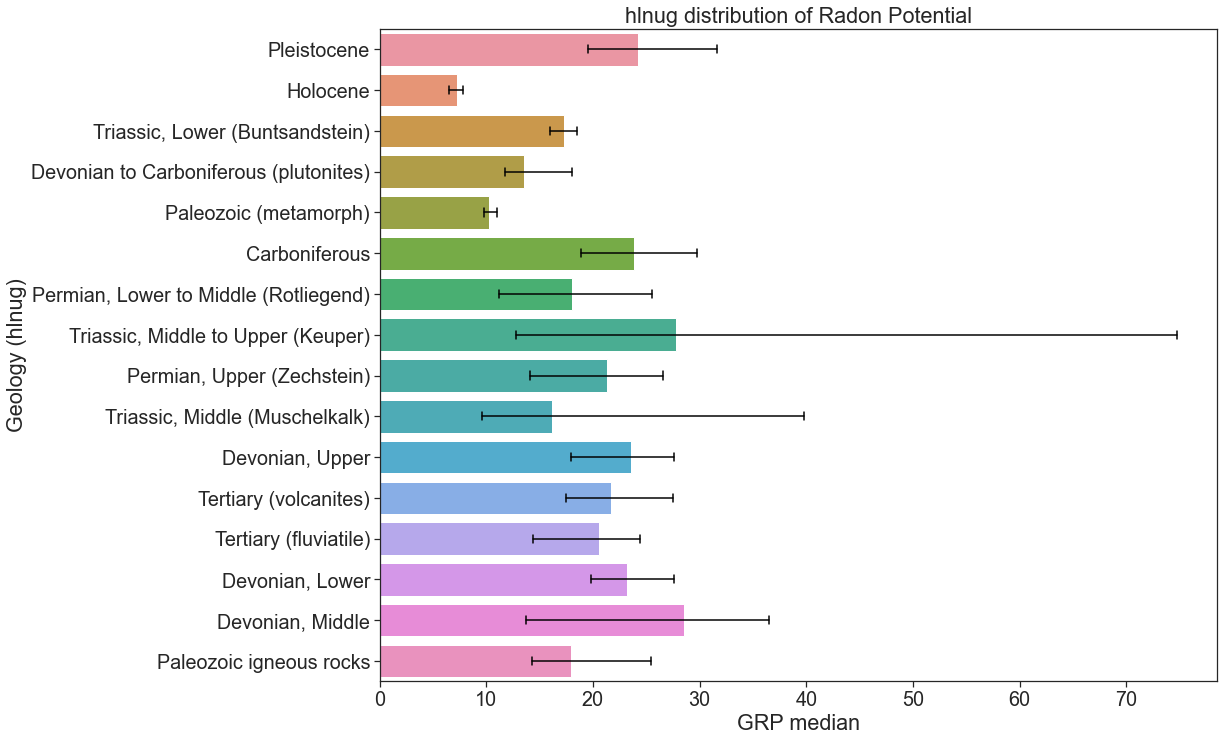

In [119]:
#plotting geology and radon based on Median
sns.set_theme(style='ticks', font_scale=1.8)
plt.figure(figsize=(15,12))
#Plotting mean values of geology
sns.barplot(y='hlnug_right', x='Rn_Poten', 
            data=  Geo_Radon, estimator= np.median,
            errcolor = 'black', errwidth = 1.5,
            capsize=0.2)
plt.ylabel ('Geology (hlnug)')
plt.xlabel ('GRP median')
plt.title('hlnug distribution of Radon Potential')
# plt.savefig('hlnug and radon based on Median.png', dpi='figure')

In [120]:
# def to_code(series):
#     return series.dt.date

# df[list_of_cols_to_change] = df[list_of_cols_to_change].apply(to_date)

In [121]:
Geology.columns

Index(['FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL', 'STRATIGRAP',
       'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM', 'BEMERKUNGE',
       'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug', 'Geo_class',
       'Shape_Le_1', 'Shape_Area', 'geometry', 'hlnug_rank',
       'strata_condense_rank', 'percentile_90'],
      dtype='object')

In [122]:
Geology.columns

Index(['FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL', 'STRATIGRAP',
       'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM', 'BEMERKUNGE',
       'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug', 'Geo_class',
       'Shape_Le_1', 'Shape_Area', 'geometry', 'hlnug_rank',
       'strata_condense_rank', 'percentile_90'],
      dtype='object')

In [123]:
Geology_ranked = Geology[['FID_1', 'strata_condense', 'hlnug',
                          'hlnug_rank','strata_condense_rank',
                          'geometry']]
Geology_ranked

FID_1 strata_condense                               hlnug  hlnug_rank  \
0      8467        Triassic      Triassic, Middle (Muschelkalk)         9.0   
1      8995        Triassic      Triassic, Middle (Muschelkalk)         9.0   
2      9067        Triassic     Triassic, Lower (Buntsandstein)        13.0   
3      9258        Triassic  Triassic, Middle to Upper (Keuper)         2.0   
4      9313        Holocene                            Holocene        15.0   
...     ...             ...                                 ...         ...   
1404  22651        Devonian                    Devonian, Middle        11.0   
1405  22652        Tertiary               Tertiary (fluviatile)         3.0   
1406  22653        Devonian                     Devonian, Upper        12.0   
1407  22677        Holocene                            Holocene        15.0   
1408  13292         Permian          Permian, Upper (Zechstein)        10.0   

      strata_condense_rank                                           geometry  
0                      7.0  POLYGON ((526957.795 5719576.918, 526874.515 5...  
1                      7.0  MULTIPOLYGON (((554799.185 5693488.116, 554799...  
2                      7.0  POLYGON ((529681.632 5699891.651, 529525.232 5...  
3                      7.0  MULTIPOLYGON (((521536.132 5708886.694, 521537...  
4                      9.0  POLYGON ((539213.415 5719626.798, 539093.241 5...  
...                    ...                                                ...  
1404                   4.0  POLYGON ((466203.699 5616491.527, 466265.279 5...  
1405                   2.0  POLYGON ((441613.654 5616737.270, 441782.466 5...  
1406                   4.0  POLYGON ((444817.044 5616120.064, 444785.037 5...  
1407                   9.0  MULTIPOLYGON (((458169.729 5492770.617, 458210...  
1408                   5.0  POLYGON ((502245.206 5572168.372, 502186.578 5...  

[1409 rows x 6 columns]

**1. strata_condense (sc)**

In [124]:
sc_Median_value_by_strata = pd.DataFrame(Geo_Radon.groupby("strata_condense").Rn_Poten
                                      .agg(['min','max',
                                            'mean','median',
                                            'count','std']))
# print(pd.DataFrame(Median_value_by_strata))
sc_Median_value_by_strata['Rank'] = sc_Median_value_by_strata['median'].rank(ascending=False)
## sort by rank
sc_Median_value_by_strata = sc_Median_value_by_strata.sort_values('Rank')
sc_Median_value_by_strata

min       max       mean     median  count        std  \
strata_condense                                                                
Pleistocene       1.219799  630.2700  51.128079  24.240750    148  81.687818   
Carboniferous     4.578420  133.3460  31.334686  23.913000     41  22.943445   
Paleozoic        12.669600   50.0442  26.419625  21.482350      4  16.315881   
Tertiary          1.368820  321.3110  32.236821  21.172800     96  41.196267   
Permian           4.719610   68.5312  23.278808  20.318500     38  15.500080   
Devonian          1.510020  279.9990  27.921434  20.257200    205  29.402974   
Triassic          1.592980  333.9880  23.989044  17.371100    204  31.648174   
Precambrian       1.216170   51.1952  12.274193  10.508042    139   6.863921   
Holocene          1.041721  141.7740  10.158912   7.231682    549  11.052057   

                 Rank  
strata_condense        
Pleistocene       1.0  
Carboniferous     2.0  
Paleozoic         3.0  
Tertiary          4.0  
Permian           5.0  
Devonian          6.0  
Triassic          7.0  
Precambrian       8.0  
Holocene          9.0

Text(0.5, 1.0, 'strata_condense distribution of Radon Potential')

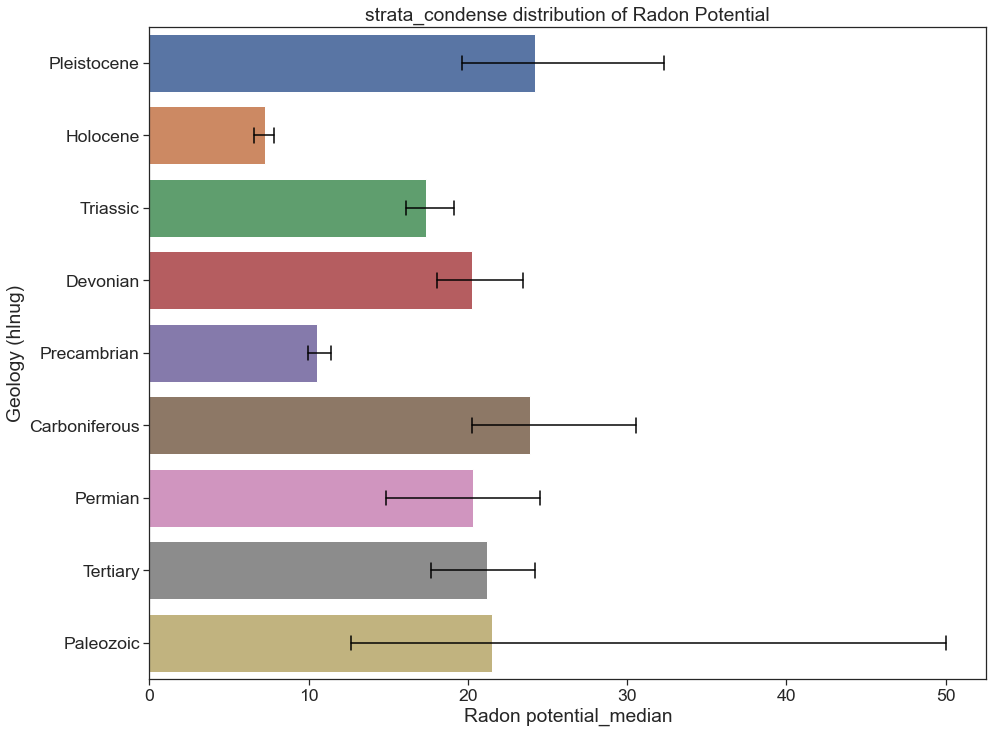

In [125]:
#plotting geology and radon based on Median
sns.set_theme(style='ticks', font_scale=1.6)
plt.figure(figsize=(15,12))
#Plotting mean values of geology
sns.barplot(y='strata_condense', x='Rn_Poten', 
            data=  Geo_Radon, estimator= np.median,
            errcolor = 'black', errwidth = 1.5,
            capsize=0.2)
plt.ylabel ('Geology (hlnug)')
plt.xlabel ('Radon potential_median')
plt.title('strata_condense distribution of Radon Potential')
# plt.savefig('strata_condense and radon based on Median.png', dpi='figure')

In [126]:
Radon_m = gpd.read_file("Radon Hessen/Final Rn data.shp")

In [127]:
Geo_Radon.columns

Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug_left', 'geometry',
       'index_right', 'FID_1', 'AREA', 'PERIMETER', 'GEO', 'SYMBOL',
       'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'GEN_SYM', 'PETROGRAPH', 'PET_SYM',
       'BEMERKUNGE', 'SHAPE_Leng', 'Strat', 'strata_condense', 'hlnug_right',
       'Geo_class', 'Shape_Le_1', 'Shape_Area'],
      dtype='object')

In [128]:
#adding hlnug to master data
Geo_rJoined = Geo_Radon[['hlnug_right','geometry']]
print(Radon_m.crs == Geology.crs)
Radon_master= gpd.sjoin(Radon_m, Geo_rJoined, how='inner', predicate='within')
# Geo_Radon.head(3)
# Geo_Radon.columns
Radon_master.columns

True


Index(['OSTWERT', 'NORDWERT', 'Rn_Poten', 'PERMEABILI', 'RADON_RN_2',
       'RADON_RN_3', 'RnKONZE', 'Strat2', 'hlnug', 'geometry', 'index_right',
       'hlnug_right'],
      dtype='object')

In [129]:
Geo_rJoined

hlnug_right                        geometry
0     Pleistocene  POINT (481853.162 5578395.410)
1     Pleistocene  POINT (481881.152 5578355.426)
2     Pleistocene  POINT (481914.138 5578338.433)
3     Pleistocene  POINT (481939.128 5578313.443)
4     Pleistocene  POINT (481949.124 5578300.449)
...           ...                             ...
956   Pleistocene  POINT (466310.000 5524499.000)
957   Pleistocene  POINT (466209.000 5524492.000)
1002  Pleistocene  POINT (466952.000 5522942.000)
1003  Pleistocene  POINT (466955.000 5522938.000)
1008  Pleistocene  POINT (466953.000 5522940.000)

[1424 rows x 2 columns]

In [130]:
# export to shapefile
# Radon_master.to_file('Radon_master.shp')
# Geology_ranked.to_file('Geo_rank.shp')

In [131]:
## exporting to geopackage
# import fiona; help(fiona.open)

# Geo_Radon.to_file("Rn_Analysis.gpkg", layer='Geo Rn data', driver="GPKG")
# Radon_master.to_file("Rn_Analysis.gpkg", layer='Radon_master data', driver="GPKG")

**------> Uranium Analysis**

In [132]:
Uranium = gpd.read_file('Uranium/Uranium_processed.shp')
df = gpd.read_file('Uranium/Uranium.shp')
Hessen = gpd.read_file("Radon Hessen/AOI_Hessen.shp")

df.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.01, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [133]:
Uranium.shape #(1184, 7)
Uranium.head(2)
# Uranium.describe()

U_PPM KONZ_URAN_  Kriging_Ur  OBJECTID  RASTERVALU  GEO SYMBOL  \
0  0.658554         <5     1.43324         2    1.759810  791   t/+B   
1  0.100000         <5     2.31606         3    0.892488  791   t/+B   

  STRATIGRAP STRAT_SYM                GENESE  ...  \
0    Terti„r         t  Effusivgestein: Lava  ...   
1    Terti„r         t  Effusivgestein: Lava  ...   

                                          BEMERKUNGE    Strat2  \
0  auch einige Vorkommen mit Trachyt, Phonolith, ...  Tertiary   
1  auch einige Vorkommen mit Trachyt, Phonolith, ...  Tertiary   

                   hlnug GEO_ID                   FORMATION  \
0  Tertiary (volcanites)      4     Fließerde, ungegliedert   
1  Tertiary (volcanites)      2  Auensediment, ungegliedert   

                                     PETROGRA_1 SUBGRUPPE       SERIE  \
0  Ton, Schluff, oft mit Steinen, Grus und Sand       NaN  Pleistozän   
1                              Lehm, Sand, Kies       NaN     Holozän   

    SYSTEM                        geometry  
0  Quartär  POINT (479393.315 5548319.759)  
1  Quartär  POINT (502381.627 5614338.351)  

[2 rows x 21 columns]

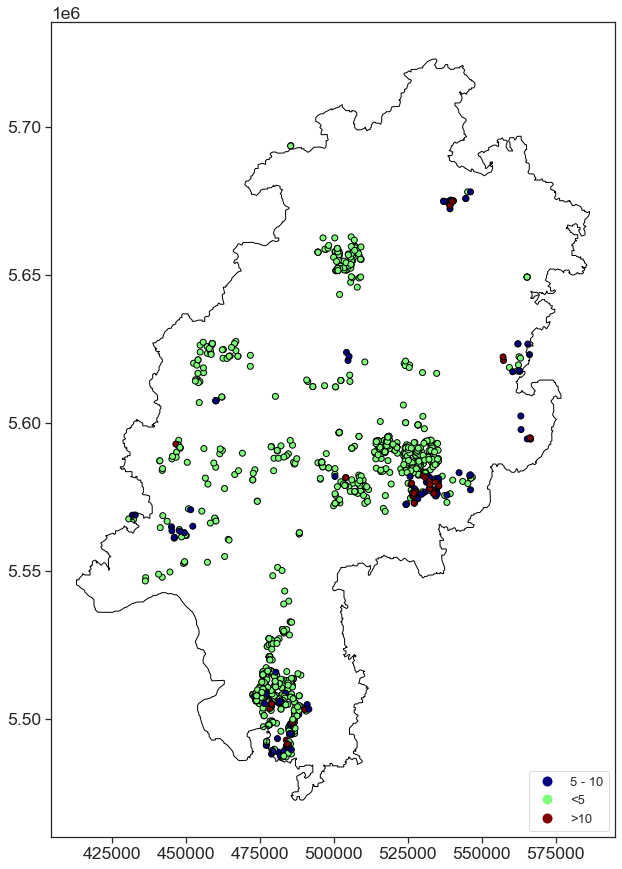

In [134]:
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Uranium.plot(ax = ax, column = 'KONZ_URAN_', cmap = 'jet',
             figsize = (15,15),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
ax2 = Hessen.plot(ax = ax, column = 'NAME_1',
                  facecolor="none", edgecolor="black")
# plt.savefig('Uranium point data.png', dpi='figure')

In [135]:
Uranium_desc = pd.DataFrame(Uranium.describe())
Uranium_desc
# dfi.export(Uranium_desc, 'Ur_describe.png')

U_PPM   Kriging_Ur     OBJECTID   RASTERVALU          GEO  \
count  1184.000000  1184.000000  1184.000000  1184.000000  1184.000000   
mean      2.802010     2.589690   489.125000     2.320494   638.015203   
std       3.117623     1.947915   373.789528     3.008494   286.868503   
min       0.017647     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.271197   130.750000     0.811392   670.000000   
50%       1.891745     2.264020   466.500000     1.750155   791.000000   
75%       3.436404     2.910297   813.250000     2.864362   791.000000   
max      38.000000    10.909000  1183.000000    47.430300   839.000000   

            GEO_ID  
count  1184.000000  
mean     40.233953  
std      38.983797  
min       0.000000  
25%      12.000000  
50%      12.000000  
75%      85.000000  
max     106.000000

Text(0.5, 1.0, 'U conc. (ppm) by interval')

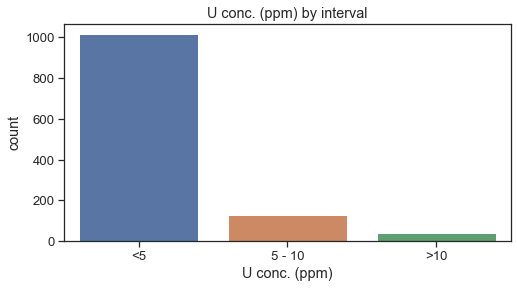

In [136]:
#Setting theme for plots
#COUNTplot for UR
sns.set_theme(style='ticks', font_scale=1.2)
plt.figure(figsize=(8,4))
sns.countplot(x=Uranium['KONZ_URAN_'])

plt.ylabel ('count')
plt.xlabel ('U conc. (ppm)')
plt.title('U conc. (ppm) by interval')
# plt.savefig('U conc. (ppm) by interval.png', dpi='figure')

Text(0.5, 1.0, 'Box plot of U conc. (ppm) by interval')

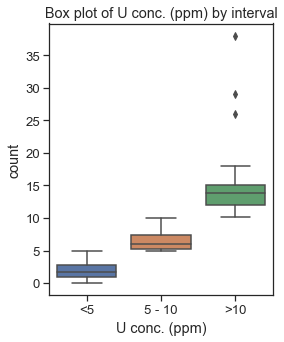

In [137]:
#BOXplot of Ur
sns.set_theme(style='ticks', font_scale=1.2)
plt.figure(figsize=(4,5))
sns.boxplot(data=Uranium, x='KONZ_URAN_',
            y='U_PPM' ,dodge=False)
plt.ylabel ('count')
plt.xlabel ('U conc. (ppm)')
plt.title('Box plot of U conc. (ppm) by interval')
# plt.savefig('BOXplot of U conc. (ppm) by interval.png', dpi='figure')

## Creating a Uranium Map

In [138]:
import seaborn as sns

<AxesSubplot:xlabel='U_PPM', ylabel='hlnug'>

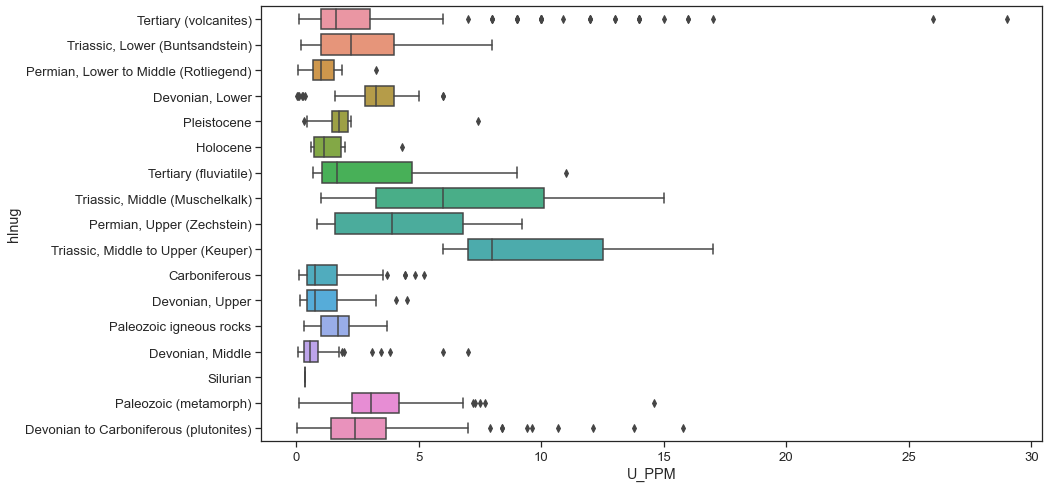

In [139]:
sns.set_theme(style='ticks', font_scale=1.2)
plt.figure(figsize=(14,8))
sns.boxplot(data=Uranium, y='hlnug', x='U_PPM')

In [140]:
# import dataframe_image as dfi

# dfi.export(df, 'dataframe.png')
# df = pd.DataFrame(np.random.rand(6,4))
# df_styled = df.style.background_gradient()


In [141]:
def Uranium_strata_median():
    data = pd.DataFrame(Uranium.groupby("hlnug").U_PPM
                    .agg(['min','max',
                          'mean','median',
                          'count','std']))
    data['Rank'] = data['median'].rank(ascending=False)
    Uranium_stat_median = data.sort_values('Rank')
    Uranium_stat_median = np.round(Uranium_stat_median, decimals=2)
    
    return Uranium_stat_median
Uranium_strata_median()

min    max   mean  median  count  \
hlnug                                                                       
Triassic, Middle to Upper (Keuper)      6.00  17.00  10.33    8.00      3   
Triassic, Middle (Muschelkalk)          1.00  15.00   6.71    6.00     14   
Permian, Upper (Zechstein)              0.85   9.20   4.46    3.90      4   
Devonian, Lower                         0.03   6.00   3.11    3.26     41   
Paleozoic (metamorph)                   0.12  14.60   3.58    3.05     66   
Devonian to Carboniferous (plutonites)  0.02  15.80   2.83    2.40    215   
Triassic, Lower (Buntsandstein)         0.17   8.00   2.84    2.25     40   
Pleistocene                             0.33   7.40   2.17    1.73      9   
Paleozoic igneous rocks                 0.31   3.71   1.69    1.71     17   
Tertiary (fluviatile)                   0.69  11.00   3.07    1.65     22   
Tertiary (volcanites)                   0.10  29.00   2.72    1.61    369   
Holocene                                0.59   4.30   1.64    1.15      6   
Permian, Lower to Middle (Rotliegend)   0.08   3.27   1.12    1.00     19   
Devonian, Upper                         0.14   4.52   1.22    0.78     38   
Carboniferous                           0.10   5.20   1.23    0.76     84   
Devonian, Middle                        0.09   7.00   0.98    0.55     58   
Silurian                                0.34   0.34   0.34    0.34      1   

                                         std  Rank  
hlnug                                               
Triassic, Middle to Upper (Keuper)      5.86   1.0  
Triassic, Middle (Muschelkalk)          4.58   2.0  
Permian, Upper (Zechstein)              3.87   3.0  
Devonian, Lower                         1.57   4.0  
Paleozoic (metamorph)                   2.25   5.0  
Devonian to Carboniferous (plutonites)  2.23   6.0  
Triassic, Lower (Buntsandstein)         2.04   7.0  
Pleistocene                             2.08   8.0  
Paleozoic igneous rocks                 1.03   9.0  
Tertiary (fluviatile)                   2.90  10.0  
Tertiary (volcanites)                   3.48  11.0  
Holocene                                1.40  12.0  
Permian, Lower to Middle (Rotliegend)   0.75  13.0  
Devonian, Upper                         1.09  14.0  
Carboniferous                           1.17  15.0  
Devonian, Middle                        1.30  16.0  
Silurian                                 NaN  17.0

In [142]:
Ur_classM = Uranium_strata_median()
Ur_classM = Ur_classM.reset_index()
Ur_classM

hlnug   min    max   mean  median  count  \
0       Triassic, Middle to Upper (Keuper)  6.00  17.00  10.33    8.00      3   
1           Triassic, Middle (Muschelkalk)  1.00  15.00   6.71    6.00     14   
2               Permian, Upper (Zechstein)  0.85   9.20   4.46    3.90      4   
3                          Devonian, Lower  0.03   6.00   3.11    3.26     41   
4                    Paleozoic (metamorph)  0.12  14.60   3.58    3.05     66   
5   Devonian to Carboniferous (plutonites)  0.02  15.80   2.83    2.40    215   
6          Triassic, Lower (Buntsandstein)  0.17   8.00   2.84    2.25     40   
7                              Pleistocene  0.33   7.40   2.17    1.73      9   
8                  Paleozoic igneous rocks  0.31   3.71   1.69    1.71     17   
9                    Tertiary (fluviatile)  0.69  11.00   3.07    1.65     22   
10                   Tertiary (volcanites)  0.10  29.00   2.72    1.61    369   
11                                Holocene  0.59   4.30   1.64    1.15      6   
12   Permian, Lower to Middle (Rotliegend)  0.08   3.27   1.12    1.00     19   
13                         Devonian, Upper  0.14   4.52   1.22    0.78     38   
14                           Carboniferous  0.10   5.20   1.23    0.76     84   
15                        Devonian, Middle  0.09   7.00   0.98    0.55     58   
16                                Silurian  0.34   0.34   0.34    0.34      1   

     std  Rank  
0   5.86   1.0  
1   4.58   2.0  
2   3.87   3.0  
3   1.57   4.0  
4   2.25   5.0  
5   2.23   6.0  
6   2.04   7.0  
7   2.08   8.0  
8   1.03   9.0  
9   2.90  10.0  
10  3.48  11.0  
11  1.40  12.0  
12  0.75  13.0  
13  1.09  14.0  
14  1.17  15.0  
15  1.30  16.0  
16   NaN  17.0

In [143]:
def Uranium_strata_tile():
    data = pd.DataFrame(Uranium.groupby(["hlnug"]).U_PPM
                    .agg(['min','max',percentile(0.9),
                          'mean','median',
                          'count','std']))
    data['Rank'] = data['percentile_90'].rank(ascending=False)
    Uranium_stat_tile = data.sort_values('Rank')
    Uranium_stat_tile = np.round(Uranium_stat_tile, decimals=2)
    
    return Uranium_stat_tile
Uranium_strata_tile()

min    max  percentile_90   mean  \
hlnug                                                                       
Triassic, Middle to Upper (Keuper)      6.00  17.00          15.20  10.33   
Triassic, Middle (Muschelkalk)          1.00  15.00          13.40   6.71   
Permian, Upper (Zechstein)              0.85   9.20           8.24   4.46   
Tertiary (fluviatile)                   0.69  11.00           6.90   3.07   
Paleozoic (metamorph)                   0.12  14.60           6.65   3.58   
Triassic, Lower (Buntsandstein)         0.17   8.00           6.00   2.84   
Tertiary (volcanites)                   0.10  29.00           6.00   2.72   
Devonian, Lower                         0.03   6.00           5.00   3.11   
Devonian to Carboniferous (plutonites)  0.02  15.80           4.81   2.83   
Pleistocene                             0.33   7.40           3.26   2.17   
Holocene                                0.59   4.30           3.15   1.64   
Paleozoic igneous rocks                 0.31   3.71           2.98   1.69   
Carboniferous                           0.10   5.20           2.93   1.23   
Devonian, Upper                         0.14   4.52           2.72   1.22   
Devonian, Middle                        0.09   7.00           1.90   0.98   
Permian, Lower to Middle (Rotliegend)   0.08   3.27           1.73   1.12   
Silurian                                0.34   0.34           0.34   0.34   

                                        median  count   std  Rank  
hlnug                                                              
Triassic, Middle to Upper (Keuper)        8.00      3  5.86   1.0  
Triassic, Middle (Muschelkalk)            6.00     14  4.58   2.0  
Permian, Upper (Zechstein)                3.90      4  3.87   3.0  
Tertiary (fluviatile)                     1.65     22  2.90   4.0  
Paleozoic (metamorph)                     3.05     66  2.25   5.0  
Triassic, Lower (Buntsandstein)           2.25     40  2.04   6.5  
Tertiary (volcanites)                     1.61    369  3.48   6.5  
Devonian, Lower                           3.26     41  1.57   8.0  
Devonian to Carboniferous (plutonites)    2.40    215  2.23   9.0  
Pleistocene                               1.73      9  2.08  10.0  
Holocene                                  1.15      6  1.40  11.0  
Paleozoic igneous rocks                   1.71     17  1.03  12.0  
Carboniferous                             0.76     84  1.17  13.0  
Devonian, Upper                           0.78     38  1.09  14.0  
Devonian, Middle                          0.55     58  1.30  15.0  
Permian, Lower to Middle (Rotliegend)     1.00     19  0.75  16.0  
Silurian                                  0.34      1   NaN  17.0

In [144]:
Ur_class = Uranium_strata_tile()
Ur_class = Ur_class.reset_index()
Ur_class = np.round(Ur_class, decimals=2)

Ur_class

hlnug   min    max  percentile_90   mean  \
0       Triassic, Middle to Upper (Keuper)  6.00  17.00          15.20  10.33   
1           Triassic, Middle (Muschelkalk)  1.00  15.00          13.40   6.71   
2               Permian, Upper (Zechstein)  0.85   9.20           8.24   4.46   
3                    Tertiary (fluviatile)  0.69  11.00           6.90   3.07   
4                    Paleozoic (metamorph)  0.12  14.60           6.65   3.58   
5          Triassic, Lower (Buntsandstein)  0.17   8.00           6.00   2.84   
6                    Tertiary (volcanites)  0.10  29.00           6.00   2.72   
7                          Devonian, Lower  0.03   6.00           5.00   3.11   
8   Devonian to Carboniferous (plutonites)  0.02  15.80           4.81   2.83   
9                              Pleistocene  0.33   7.40           3.26   2.17   
10                                Holocene  0.59   4.30           3.15   1.64   
11                 Paleozoic igneous rocks  0.31   3.71           2.98   1.69   
12                           Carboniferous  0.10   5.20           2.93   1.23   
13                         Devonian, Upper  0.14   4.52           2.72   1.22   
14                        Devonian, Middle  0.09   7.00           1.90   0.98   
15   Permian, Lower to Middle (Rotliegend)  0.08   3.27           1.73   1.12   
16                                Silurian  0.34   0.34           0.34   0.34   

    median  count   std  Rank  
0     8.00      3  5.86   1.0  
1     6.00     14  4.58   2.0  
2     3.90      4  3.87   3.0  
3     1.65     22  2.90   4.0  
4     3.05     66  2.25   5.0  
5     2.25     40  2.04   6.5  
6     1.61    369  3.48   6.5  
7     3.26     41  1.57   8.0  
8     2.40    215  2.23   9.0  
9     1.73      9  2.08  10.0  
10    1.15      6  1.40  11.0  
11    1.71     17  1.03  12.0  
12    0.76     84  1.17  13.0  
13    0.78     38  1.09  14.0  
14    0.55     58  1.30  15.0  
15    1.00     19  0.75  16.0  
16    0.34      1   NaN  17.0

In [145]:
# dfi.export(Ur_class, 'Ur_class.png')
# dfi.export(Ur_class, 'Ur_class.png')

In [146]:
Lk = gpd.read_file("Geology_Hessen/Landkreis_.shp")
Lk.head()

OBJECTID KREISNR             KREISNAME  KREISNR_ZA    LK_Flaeche  \
0         1     411       Stadt Darmstadt         411  1.221290e+08   
1         2     412  Stadt Frankfurt/Main         412  2.481567e+08   
2         3     413  Stadt Offenbach/Main         413  4.485543e+07   
3         4     414       Stadt Wiesbaden         414  2.037322e+08   
4         5     431            Bergstraße         431  7.189030e+08   

   MITTELWERT  RP_KAT_LK     Shape_Leng    Shape_Area  \
0       13.21          1   66510.893662  1.221290e+08   
1       27.01          2  112417.091456  2.481567e+08   
2       39.50          2   41939.825028  4.485543e+07   
3       24.75          2   79786.159133  2.037322e+08   
4       36.68          2  242953.062909  7.189030e+08   

                                            geometry  
0  POLYGON ((480471.000 5533477.160, 480562.780 5...  
1  POLYGON ((479496.760 5563818.260, 479512.260 5...  
2  POLYGON ((486902.280 5552308.840, 486839.220 5...  
3  POLYGON ((448293.840 5555723.140, 448388.750 5...  
4  MULTIPOLYGON (((478557.020 5511309.820, 478526...

In [147]:
Ur_Lk = gpd.sjoin(Uranium, Lk, how='inner', predicate='within')
Ur_Lk.columns

Index(['U_PPM', 'KONZ_URAN_', 'Kriging_Ur', 'OBJECTID_left', 'RASTERVALU',
       'GEO', 'SYMBOL', 'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'PETROGRAPH',
       'BEMERKUNGE', 'Strat2', 'hlnug', 'GEO_ID', 'FORMATION', 'PETROGRA_1',
       'SUBGRUPPE', 'SERIE', 'SYSTEM', 'geometry', 'index_right',
       'OBJECTID_right', 'KREISNR', 'KREISNAME', 'KREISNR_ZA', 'LK_Flaeche',
       'MITTELWERT', 'RP_KAT_LK', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [148]:
Ur_datai = Ur_Lk[['U_PPM', 'KONZ_URAN_','PETROGRAPH',
       'hlnug', 'GEO_ID', 'PETROGRA_1',
       'geometry', 'KREISNAME','Shape_Area']]

In [149]:
Ur_datai.head(3)

U_PPM KONZ_URAN_                                         PETROGRAPH  \
0    0.658554         <5  Alkalibasalt, Basanit, Tephrit, Nephelinit, Th...   
494  1.731446         <5                                         Sand, Kies   
1    0.100000         <5  Alkalibasalt, Basanit, Tephrit, Nephelinit, Th...   

                     hlnug  GEO_ID  \
0    Tertiary (volcanites)       4   
494            Pleistocene       2   
1    Tertiary (volcanites)       2   

                                       PETROGRA_1  \
0    Ton, Schluff, oft mit Steinen, Grus und Sand   
494                              Lehm, Sand, Kies   
1                                Lehm, Sand, Kies   

                           geometry             KREISNAME    Shape_Area  
0    POINT (479393.315 5548319.759)  Stadt Frankfurt/Main  2.481567e+08  
494  POINT (481032.682 5551118.634)  Stadt Frankfurt/Main  2.481567e+08  
1    POINT (502381.627 5614338.351)            Vogelsberg  1.457633e+09

<AxesSubplot:>

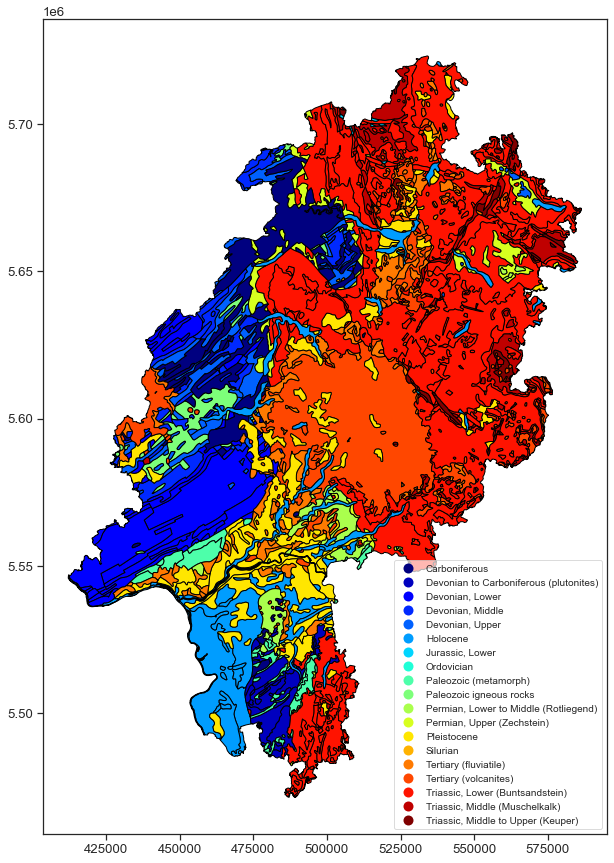

In [150]:
# plotting ''hlnug'
Geology.plot(column = 'hlnug', cmap = 'jet',
             figsize = (15,15),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':10,
                         'title_fontsize':13 })
# plt.savefig('hlnug_Geo300k.png', dpi='figure', )

In [151]:
Geology.head(3)

FID_1          AREA      PERIMETER  GEO SYMBOL  \
0   8467  6.336117e+08  477448.402231  602      m   
1   8995  2.122375e+08  162134.221355  602      m   
2   9067  1.503096e+08  169602.847544  609     so   

                          STRATIGRAP STRAT_SYM               GENESE GEN_SYM  \
0                 Trias, Muschelkalk         m  marine Ablagerungen       m   
1                 Trias, Muschelkalk         m  marine Ablagerungen       m   
2  Trias, Oberer Buntsandstein, Roet        so  marine Ablagerungen       m   

                                          PETROGRAPH  ...  \
0     Kalkstein, Mergelstein, Dolomitstein, Tonstein  ...   
1     Kalkstein, Mergelstein, Dolomitstein, Tonstein  ...   
2  roter Tonstein, mergelig, mit Salinarfolge: St...  ...   

                             Strat strata_condense  \
0   Triassic, Middle (Muschelkalk)        Triassic   
1   Triassic, Middle (Muschelkalk)        Triassic   
2  Triassic, Lower (Buntsandstein)        Triassic   

                             hlnug Geo_class     Shape_Le_1    Shape_Area  \
0   Triassic, Middle (Muschelkalk)       NaN   75541.621431  9.063963e+07   
1   Triassic, Middle (Muschelkalk)       NaN   36569.019714  1.056687e+07   
2  Triassic, Lower (Buntsandstein)       NaN  136848.585524  1.357802e+08   

                                            geometry  hlnug_rank  \
0  POLYGON ((526957.795 5719576.918, 526874.515 5...         9.0   
1  MULTIPOLYGON (((554799.185 5693488.116, 554799...         9.0   
2  POLYGON ((529681.632 5699891.651, 529525.232 5...        13.0   

   strata_condense_rank percentile_90  
0                   7.0         45.72  
1                   7.0         45.72  
2                   7.0         39.47  

[3 rows x 23 columns]

In [152]:
Uranium_cl = Geology[['AREA', 'PETROGRAPH', 'hlnug',
       'Shape_Area', 'geometry', 'hlnug_rank', 'strata_condense_rank']]
Uranium_cl.head()

AREA                                         PETROGRAPH  \
0  6.336117e+08     Kalkstein, Mergelstein, Dolomitstein, Tonstein   
1  2.122375e+08     Kalkstein, Mergelstein, Dolomitstein, Tonstein   
2  1.503096e+08  roter Tonstein, mergelig, mit Salinarfolge: St...   
3  1.157414e+08  Tonstein, Mergelstein mit Lagen von Sandstein,...   
4  3.081288e+06                               Sand, Kies, Schotter   

                                hlnug    Shape_Area  \
0      Triassic, Middle (Muschelkalk)  9.063963e+07   
1      Triassic, Middle (Muschelkalk)  1.056687e+07   
2     Triassic, Lower (Buntsandstein)  1.357802e+08   
3  Triassic, Middle to Upper (Keuper)  2.598544e+06   
4                            Holocene  1.755195e+06   

                                            geometry  hlnug_rank  \
0  POLYGON ((526957.795 5719576.918, 526874.515 5...         9.0   
1  MULTIPOLYGON (((554799.185 5693488.116, 554799...         9.0   
2  POLYGON ((529681.632 5699891.651, 529525.232 5...        13.0   
3  MULTIPOLYGON (((521536.132 5708886.694, 521537...         2.0   
4  POLYGON ((539213.415 5719626.798, 539093.241 5...        15.0   

   strata_condense_rank  
0                   7.0  
1                   7.0  
2                   7.0  
3                   7.0  
4                   9.0

In [153]:
import copy

In [154]:
Ur_class = pd.DataFrame(Ur_class)
Ur_class = np.round(Ur_class, decimals=2)
Ur_class

hlnug   min    max  percentile_90   mean  \
0       Triassic, Middle to Upper (Keuper)  6.00  17.00          15.20  10.33   
1           Triassic, Middle (Muschelkalk)  1.00  15.00          13.40   6.71   
2               Permian, Upper (Zechstein)  0.85   9.20           8.24   4.46   
3                    Tertiary (fluviatile)  0.69  11.00           6.90   3.07   
4                    Paleozoic (metamorph)  0.12  14.60           6.65   3.58   
5          Triassic, Lower (Buntsandstein)  0.17   8.00           6.00   2.84   
6                    Tertiary (volcanites)  0.10  29.00           6.00   2.72   
7                          Devonian, Lower  0.03   6.00           5.00   3.11   
8   Devonian to Carboniferous (plutonites)  0.02  15.80           4.81   2.83   
9                              Pleistocene  0.33   7.40           3.26   2.17   
10                                Holocene  0.59   4.30           3.15   1.64   
11                 Paleozoic igneous rocks  0.31   3.71           2.98   1.69   
12                           Carboniferous  0.10   5.20           2.93   1.23   
13                         Devonian, Upper  0.14   4.52           2.72   1.22   
14                        Devonian, Middle  0.09   7.00           1.90   0.98   
15   Permian, Lower to Middle (Rotliegend)  0.08   3.27           1.73   1.12   
16                                Silurian  0.34   0.34           0.34   0.34   

    median  count   std  Rank  
0     8.00      3  5.86   1.0  
1     6.00     14  4.58   2.0  
2     3.90      4  3.87   3.0  
3     1.65     22  2.90   4.0  
4     3.05     66  2.25   5.0  
5     2.25     40  2.04   6.5  
6     1.61    369  3.48   6.5  
7     3.26     41  1.57   8.0  
8     2.40    215  2.23   9.0  
9     1.73      9  2.08  10.0  
10    1.15      6  1.40  11.0  
11    1.71     17  1.03  12.0  
12    0.76     84  1.17  13.0  
13    0.78     38  1.09  14.0  
14    0.55     58  1.30  15.0  
15    1.00     19  0.75  16.0  
16    0.34      1   NaN  17.0

In [155]:
Ur_class.columns

Index(['hlnug', 'min', 'max', 'percentile_90', 'mean', 'median', 'count',
       'std', 'Rank'],
      dtype='object')

In [156]:
Uranium_cl['p_90'] = Uranium_cl['hlnug'].map(Ur_class.set_index('hlnug')['percentile_90'])
Uranium_cl['p_50'] = Uranium_cl['hlnug'].map(Ur_class.set_index('hlnug')['median'])

In [157]:
Uranium_cl.head(2)

AREA                                      PETROGRAPH  \
0  6.336117e+08  Kalkstein, Mergelstein, Dolomitstein, Tonstein   
1  2.122375e+08  Kalkstein, Mergelstein, Dolomitstein, Tonstein   

                            hlnug    Shape_Area  \
0  Triassic, Middle (Muschelkalk)  9.063963e+07   
1  Triassic, Middle (Muschelkalk)  1.056687e+07   

                                            geometry  hlnug_rank  \
0  POLYGON ((526957.795 5719576.918, 526874.515 5...         9.0   
1  MULTIPOLYGON (((554799.185 5693488.116, 554799...         9.0   

   strata_condense_rank  p_90  p_50  
0                   7.0  13.4   6.0  
1                   7.0  13.4   6.0

In [158]:
def urclass(x):
    if (x < 5):
        return '< 5'
    elif ((x >= 5) | (x <=10)):
        return '5 - 10'
    else:
        return '>10'

Uranium_cl['p_90_class'] = Uranium_cl['p_90'].apply(urclass)
Uranium_cl['p_50_class'] = Uranium_cl['p_50'].apply(urclass)

In [159]:
Uranium_cl.shape

(1409, 11)

In [160]:
Uranium.columns

Index(['U_PPM', 'KONZ_URAN_', 'Kriging_Ur', 'OBJECTID', 'RASTERVALU', 'GEO',
       'SYMBOL', 'STRATIGRAP', 'STRAT_SYM', 'GENESE', 'PETROGRAPH',
       'BEMERKUNGE', 'Strat2', 'hlnug', 'GEO_ID', 'FORMATION', 'PETROGRA_1',
       'SUBGRUPPE', 'SERIE', 'SYSTEM', 'geometry'],
      dtype='object')

In [161]:
def area():
    area_shape = pd.DataFrame(Uranium_cl.groupby(["hlnug"]).Shape_Area
                    .agg(['mean']))
    area_shape.reset_index()
    area_shape = area_shape.rename(columns={'mean': 'shape_area'})

    return area_shape
area()
area_shape = area()

In [162]:
Ur_class['Shape_area'] = Ur_class['hlnug'].map(area_shape['shape_area'])
Ur_class = np.round(Ur_class, decimals=2)
Ur_class

hlnug   min    max  percentile_90   mean  \
0       Triassic, Middle to Upper (Keuper)  6.00  17.00          15.20  10.33   
1           Triassic, Middle (Muschelkalk)  1.00  15.00          13.40   6.71   
2               Permian, Upper (Zechstein)  0.85   9.20           8.24   4.46   
3                    Tertiary (fluviatile)  0.69  11.00           6.90   3.07   
4                    Paleozoic (metamorph)  0.12  14.60           6.65   3.58   
5          Triassic, Lower (Buntsandstein)  0.17   8.00           6.00   2.84   
6                    Tertiary (volcanites)  0.10  29.00           6.00   2.72   
7                          Devonian, Lower  0.03   6.00           5.00   3.11   
8   Devonian to Carboniferous (plutonites)  0.02  15.80           4.81   2.83   
9                              Pleistocene  0.33   7.40           3.26   2.17   
10                                Holocene  0.59   4.30           3.15   1.64   
11                 Paleozoic igneous rocks  0.31   3.71           2.98   1.69   
12                           Carboniferous  0.10   5.20           2.93   1.23   
13                         Devonian, Upper  0.14   4.52           2.72   1.22   
14                        Devonian, Middle  0.09   7.00           1.90   0.98   
15   Permian, Lower to Middle (Rotliegend)  0.08   3.27           1.73   1.12   
16                                Silurian  0.34   0.34           0.34   0.34   

    median  count   std  Rank   Shape_area  
0     8.00      3  5.86   1.0   5977389.23  
1     6.00     14  4.58   2.0   6121353.00  
2     3.90      4  3.87   3.0   7462582.29  
3     1.65     22  2.90   4.0   5670097.84  
4     3.05     66  2.25   5.0   7336741.14  
5     2.25     40  2.04   6.5  25591432.50  
6     1.61    369  3.48   6.5  12462868.36  
7     3.26     41  1.57   8.0  30836693.02  
8     2.40    215  2.23   9.0   8897913.27  
9     1.73      9  2.08  10.0  20376740.49  
10    1.15      6  1.40  11.0  30330751.79  
11    1.71     17  1.03  12.0  13898184.33  
12    0.76     84  1.17  13.0  22272775.81  
13    0.78     38  1.09  14.0   9765866.36  
14    0.55     58  1.30  15.0  12532821.64  
15    1.00     19  0.75  16.0  10818177.07  
16    0.34      1   NaN  17.0    814024.39

In [163]:
# dfi.export(Ur_class, 'Ur_total_data.png')

Text(0.5, 1.0, 'p_90_classes')

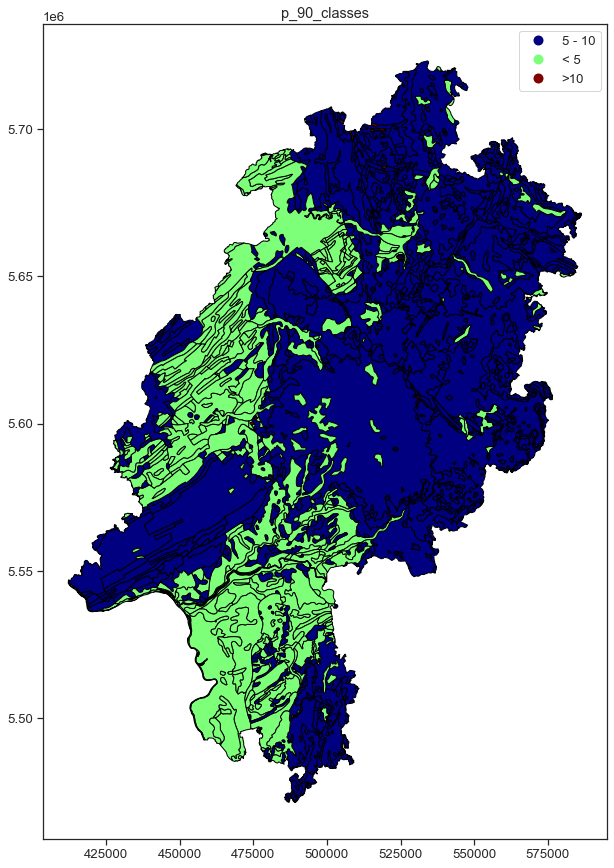

In [164]:
# plotting Radon data and Geology
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Uranium_cl.plot(ax = ax, column = 'p_90_class', cmap = 'jet',
             figsize = (18,18),edgecolor='black', legend = True)
plt.title('p_90_classes')
# ax2 = Uranium.plot(ax = ax, column = 'KONZ_URAN_',
#            cmap = 'Accent', edgecolor='black', markersize = 50, legend = True)
# plt.savefig('p_90_class.png', dpi='figure', )

Text(0.5, 1.0, 'p_50_classes')

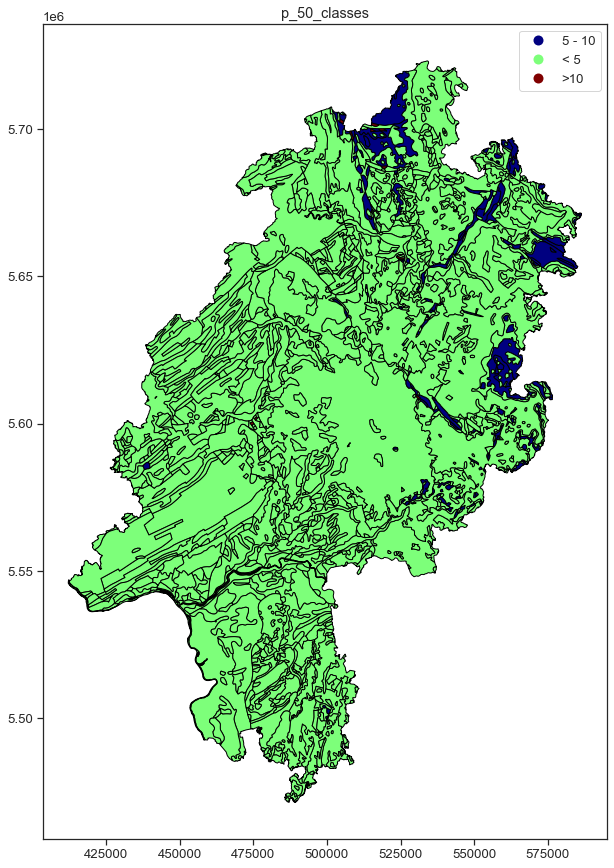

In [165]:
# plotting Radon data and Geology
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Uranium_cl.plot(ax = ax, column = 'p_50_class', cmap = 'jet',
             figsize = (18,18),edgecolor='black', legend = True)
plt.title('p_50_classes')
# ax2 = Uranium.plot(ax = ax, column = 'KONZ_URAN_',
#            cmap = 'Accent', edgecolor='black', markersize = 50, legend = True)
#plt.savefig('p_50_class.png', dpi='figure', )

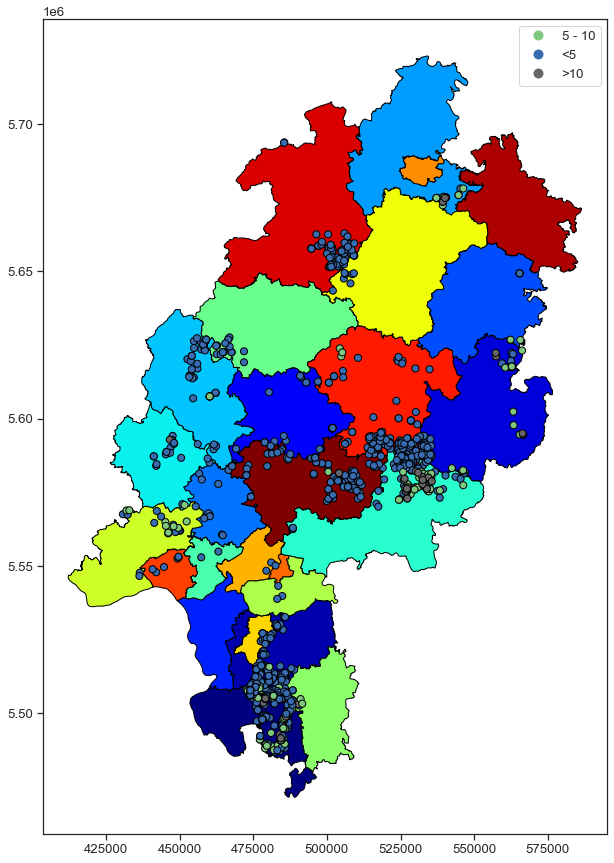

In [166]:
# plotting Radon data and Geology
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Lk.plot(ax = ax, column = 'KREISNAME', cmap = 'jet',
             figsize = (18,18),edgecolor='black', legend = True,
             legend_kwds={'loc': 4, 'framealpha': 0.7,'fontsize':13,
                         'title_fontsize':13 })
ax2 = Uranium.plot(ax = ax, column = 'KONZ_URAN_',
           cmap = 'Accent', edgecolor='black', markersize = 50, legend = True)

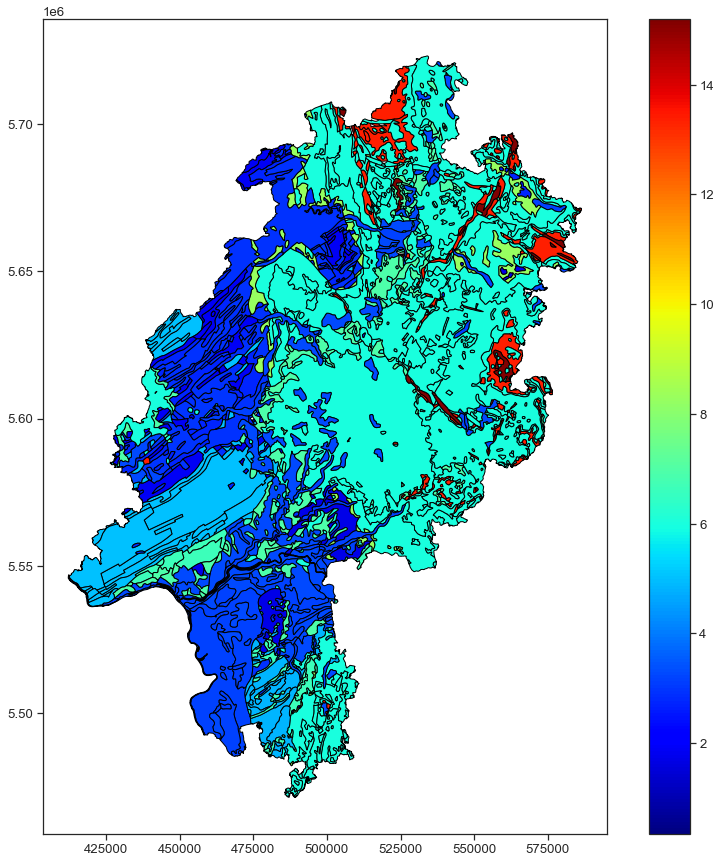

In [167]:
# plotting Radon data and Geology
fig, ax=plt.subplots(figsize = (15,15))
ax1 = Uranium_cl.plot(ax = ax, column = 'p_90', cmap = 'jet',
             figsize = (18,18),edgecolor='black', legend = True,
             )
# plt.savefig('p_90_pts.png', dpi='figure', )

In [171]:
Uranium_cl.shape

(1409, 11)

In [ ]:
Geology['percentile_90'] = Geology['hlnug'].map(Geology_strata_tile['percentile_90'])

In [168]:
Uranium_cl.to_file("Uranium_Radon_classification.gpkg", layer='Uranium_map', driver="GPKG")
Uranium_cl.to_file('Uranium_Radon_classification.shp')

In [169]:
Uranium_cl.to_file("Rn_Analysis.gpkg", layer='Uranium_map', driver="GPKG")

In [88]:
Lk.to_file("Rn_Analysis.gpkg", layer='Geo Rn data', driver="GPKG")
Uranium_cl.to_file("Rn_Analysis.gpkg", layer='Uranium_map', driver="GPKG")

In [89]:
Geology.to_file("Rn_Analysis.gpkg", layer='Geo_map', driver="GPKG")

**------> Geostatistical Analysis**